## Dataset

In [1]:
# Packages:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random as rn
import scipy.stats as ss
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

from sklearn.metrics import make_scorer, f1_score
from xgboost import XGBClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, roc_curve, auc

In [2]:
# Loading dataset:
def load_data(file):
    df = pd.read_csv(file, sep = ";")
    return df

data = load_data("Student dropout.csv")

In [3]:
# Setting seed:
seed_value = 101

np.random.seed(seed_value)
rn.seed(seed_value)

In [4]:
# Categorically encoded features:
categorical_features = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 36]
data[data.columns[categorical_features]] = data[data.columns[categorical_features]].astype("category")

## EDA Part 1

In [5]:
data 

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nationality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.0,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666.666.666.666.600,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.0,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.4,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.0,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666.666.666.666.600,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.0,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.5,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.0,0,9.4,-0.8,-3.12,Graduate


In [6]:
# Shape:
data.shape

(4424, 37)

In [7]:
# Features:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  4424 non-null   category
 1   Application mode                                4424 non-null   category
 2   Application order                               4424 non-null   category
 3   Course                                          4424 non-null   category
 4   Daytime/evening attendance                      4424 non-null   category
 5   Previous qualification                          4424 non-null   category
 6   Previous qualification (grade)                  4424 non-null   float64 
 7   Nationality                                     4424 non-null   category
 8   Mother's qualification                          4424 non-null   category
 9   Father's qualification        

In [8]:
# Missing values:
print(data.isnull().sum())

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nationality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

In [9]:
# Imbalance:
def data_distribution (df, target): 
    graduated = round(len(df[df[target] == "Graduate"]) / len(df) * 100, 2)
    dropped = round(len(df[df[target] == "Dropout"]) / len(df) * 100, 2)
    enrolled = round(len(df[df[target] == "Enrolled"]) / len(df) * 100, 2)
    return graduated, dropped, enrolled
    
data_distribution(data, "Target")

(49.93, 32.12, 17.95)

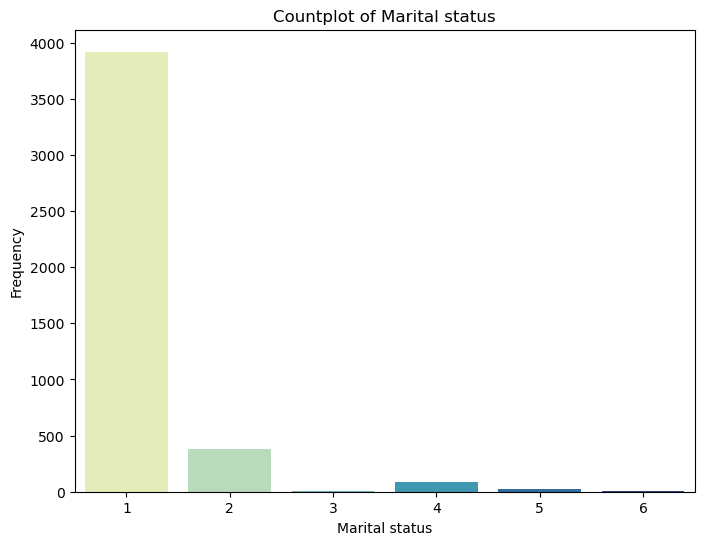

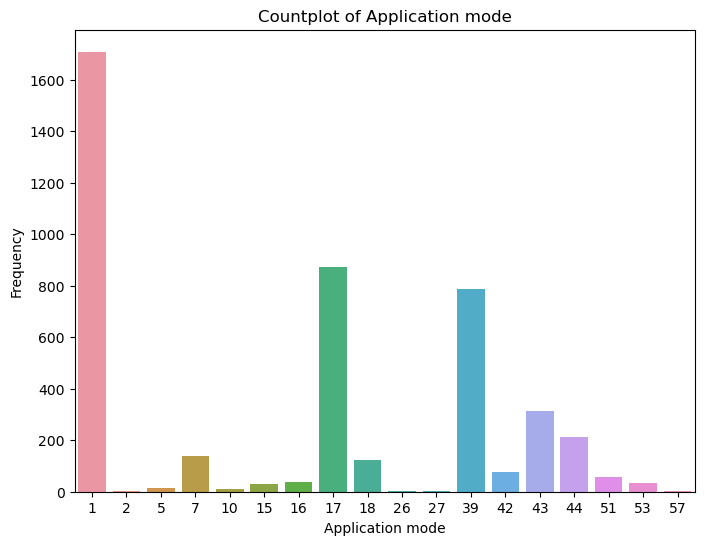

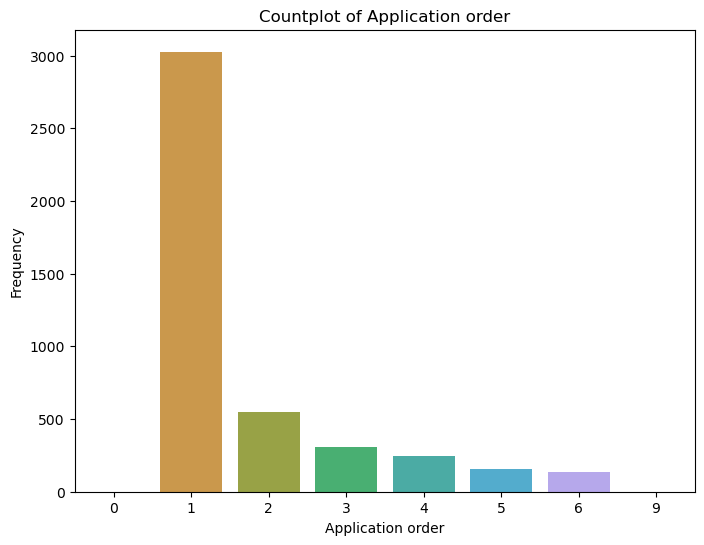

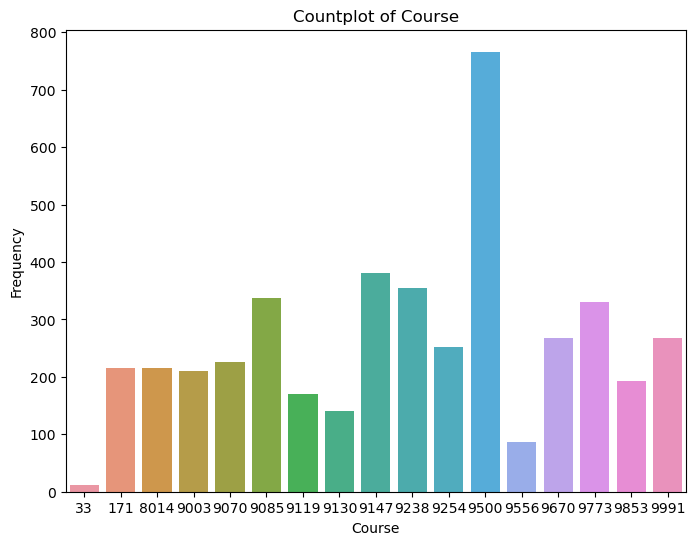

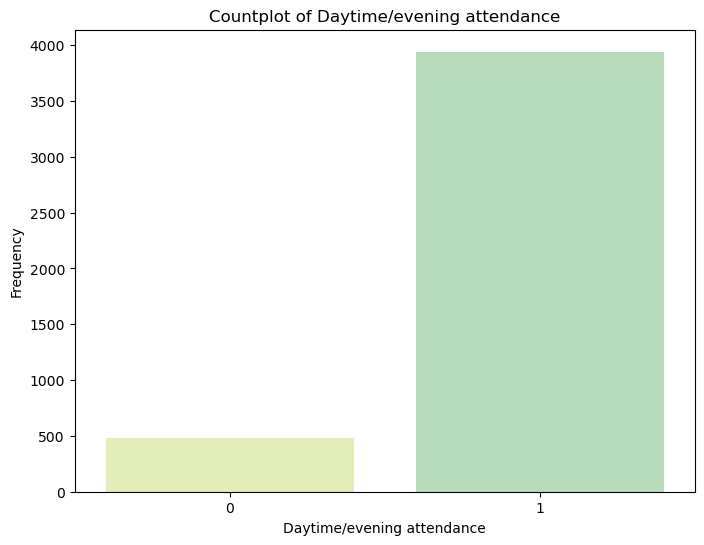

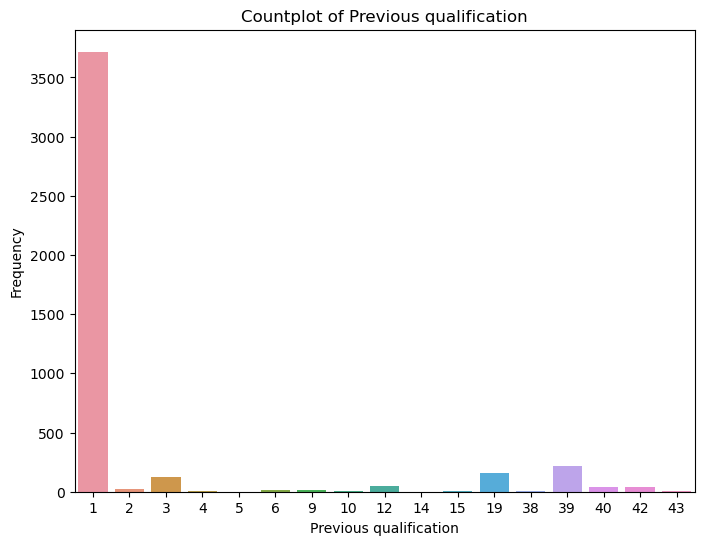

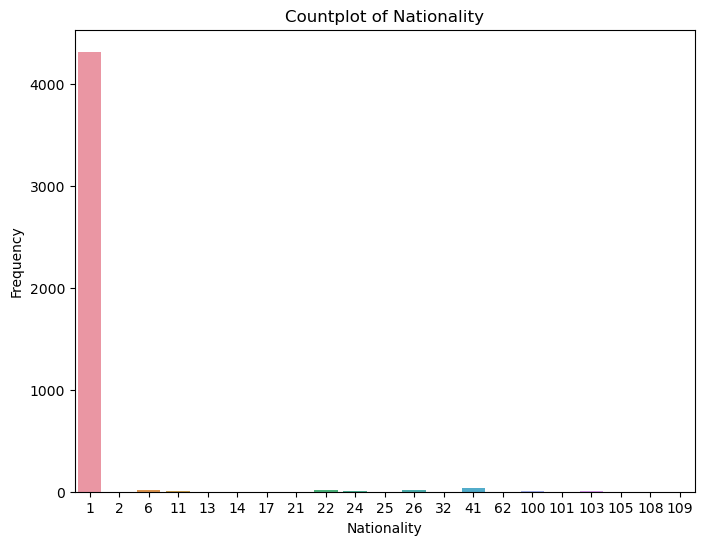

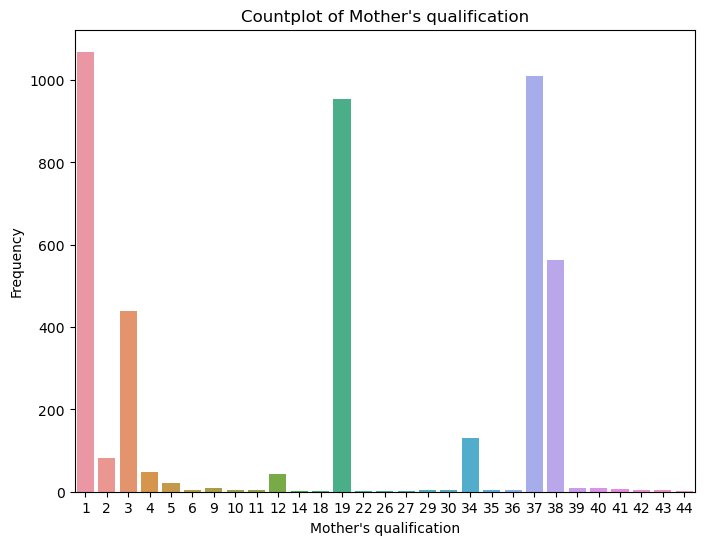

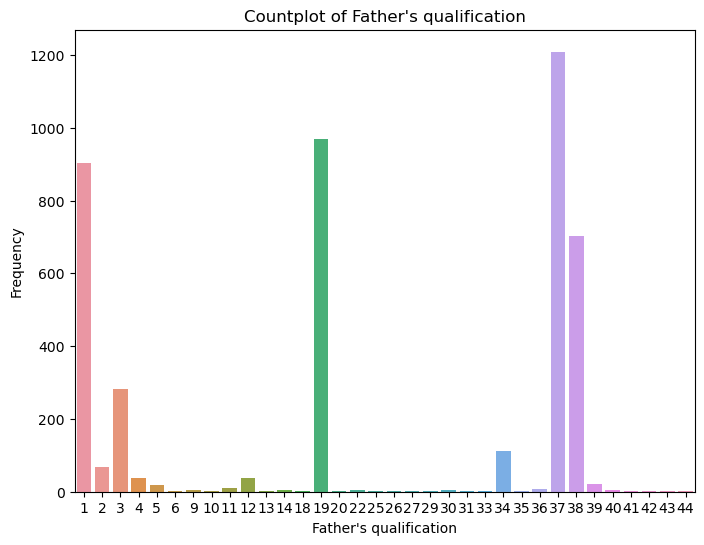

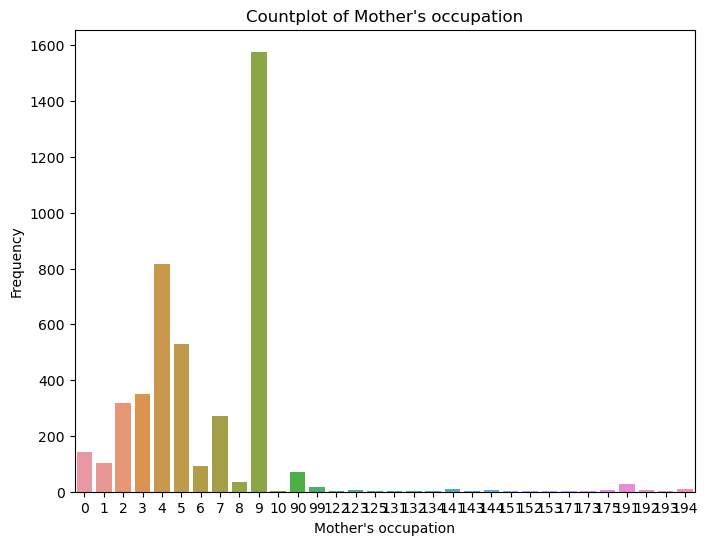

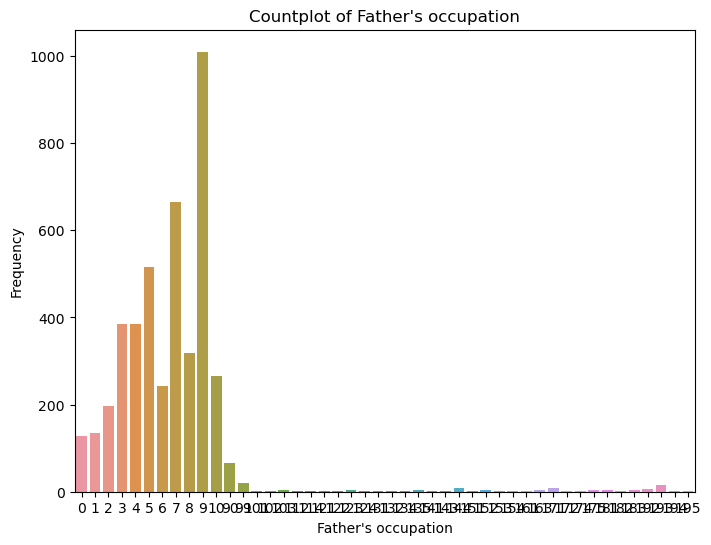

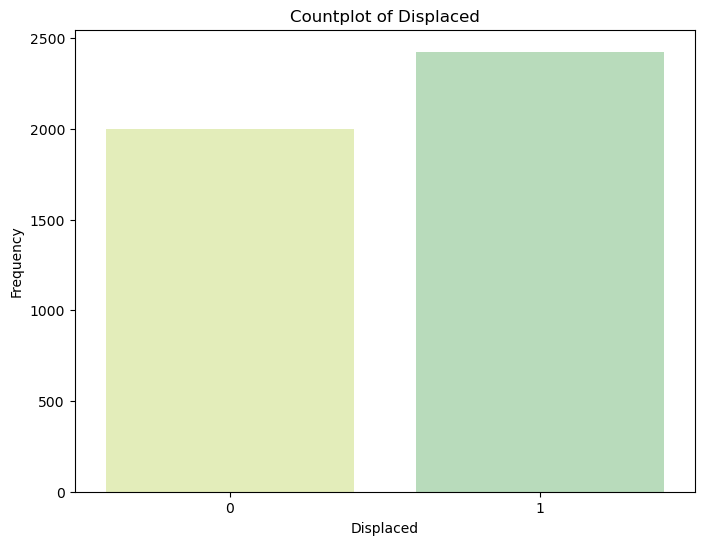

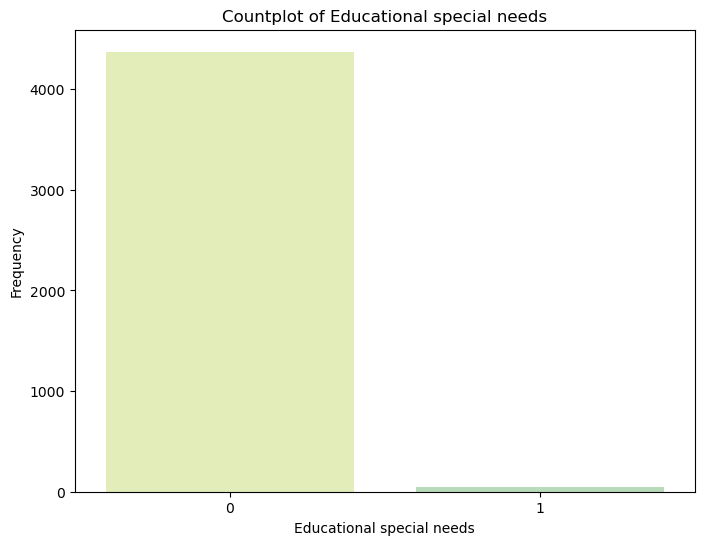

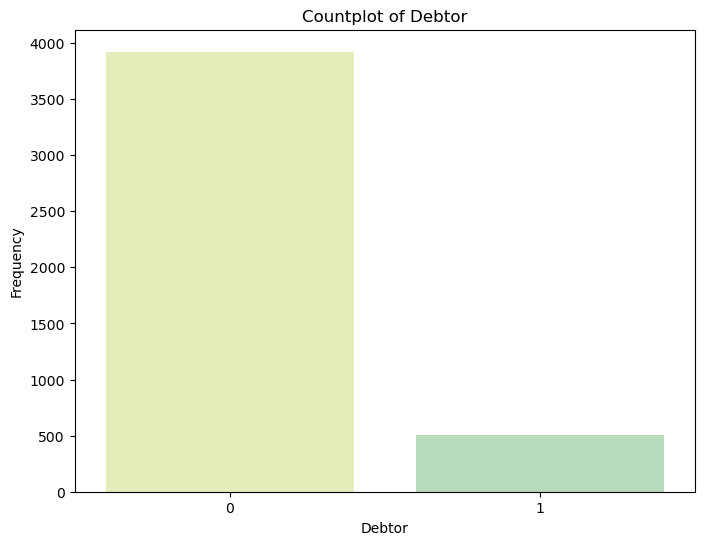

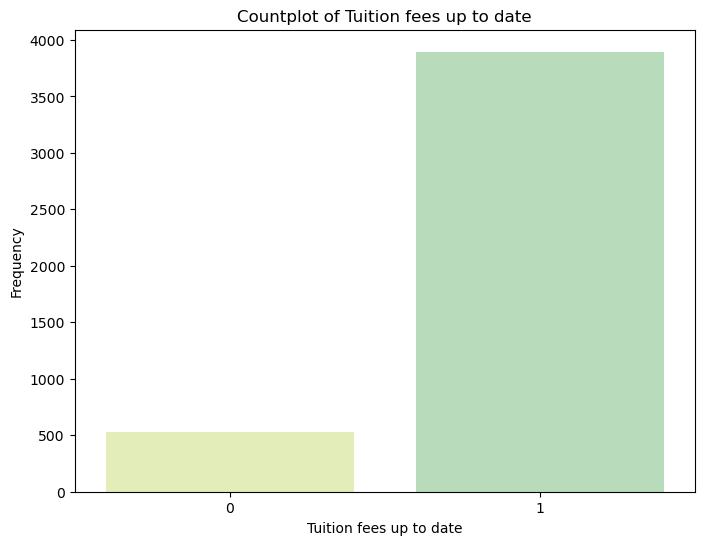

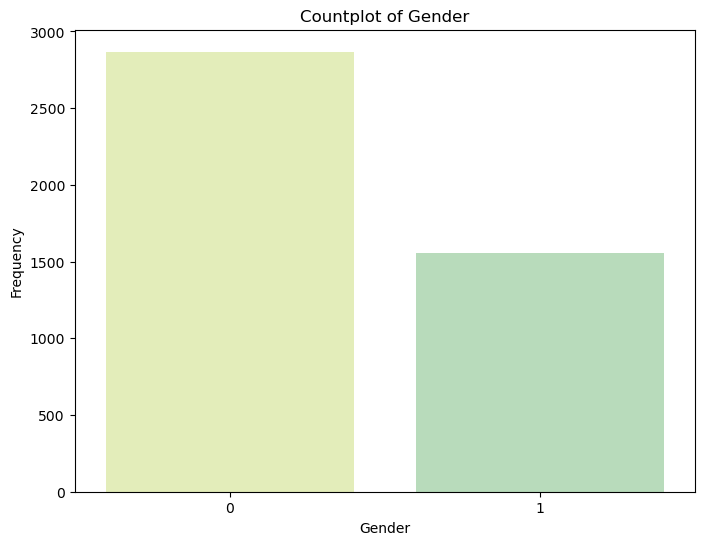

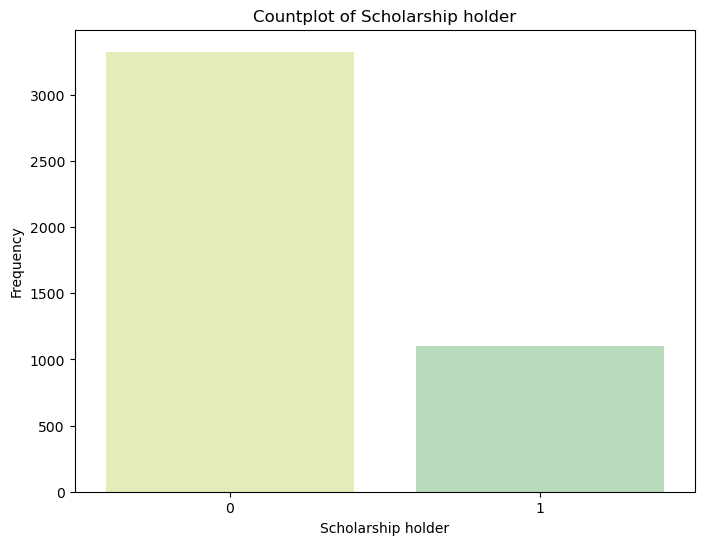

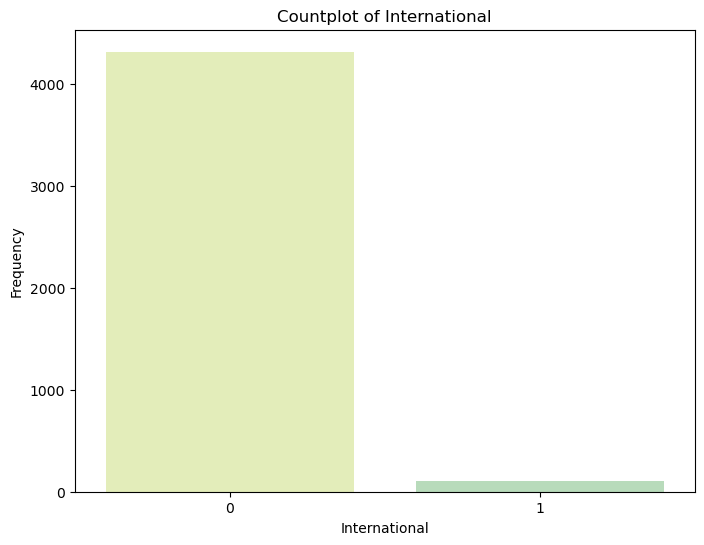

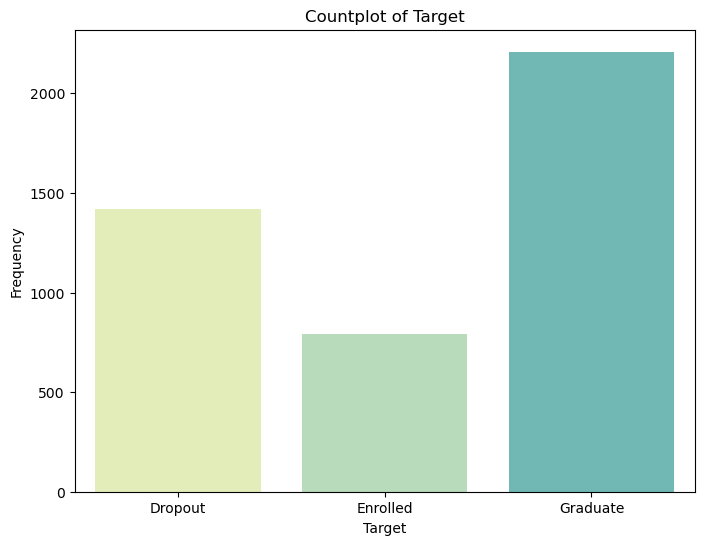

In [10]:
# Countplot for visualizing the frequency of categories in a categorical variable
def countplots(df):
    categorical_columns = df.select_dtypes(include = ["category"]).columns
    for column in categorical_columns:
        plt.figure(figsize = (8, 6))
        sns.set_palette("YlGnBu")
        order = df[column].cat.categories
        sns.countplot(x = column, data = df, order = order)
        plt.title(f"Countplot of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

countplots(data)

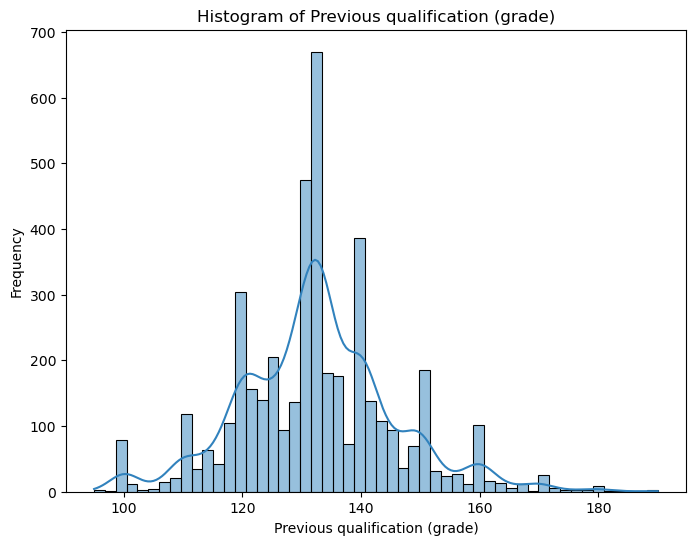

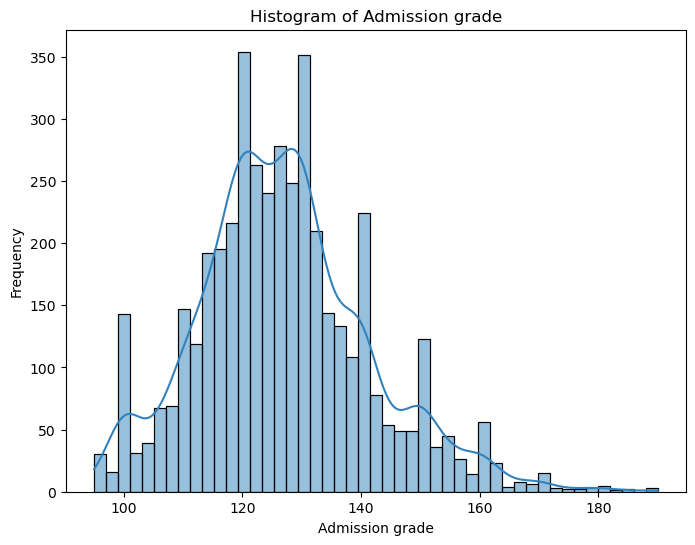

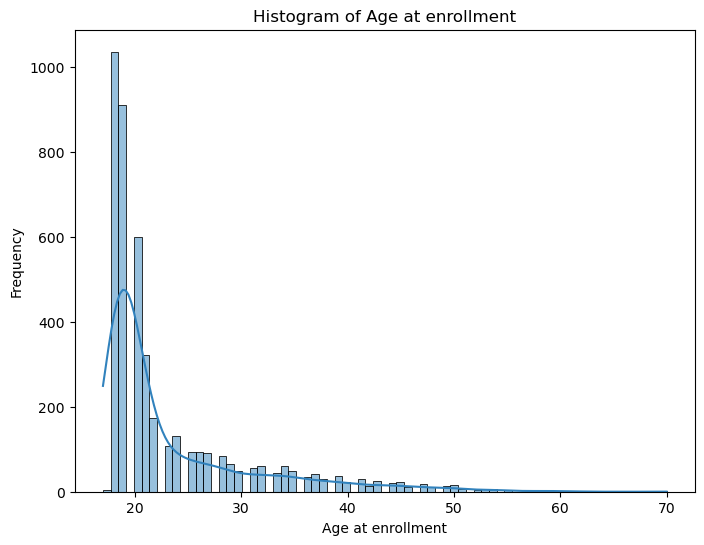

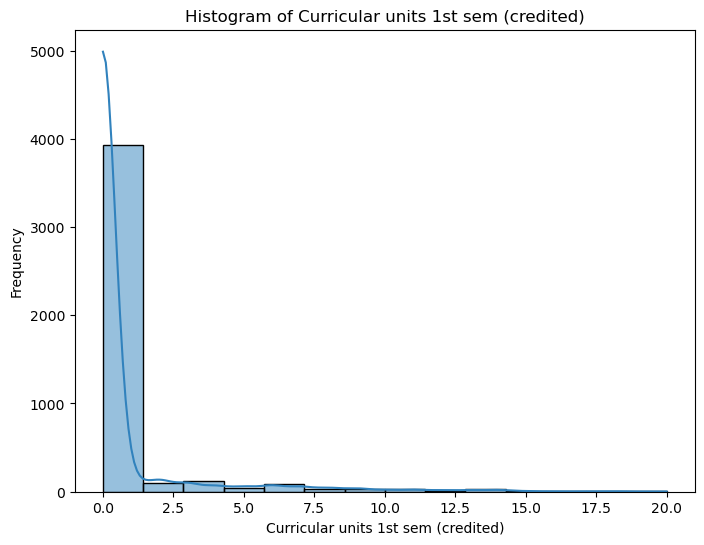

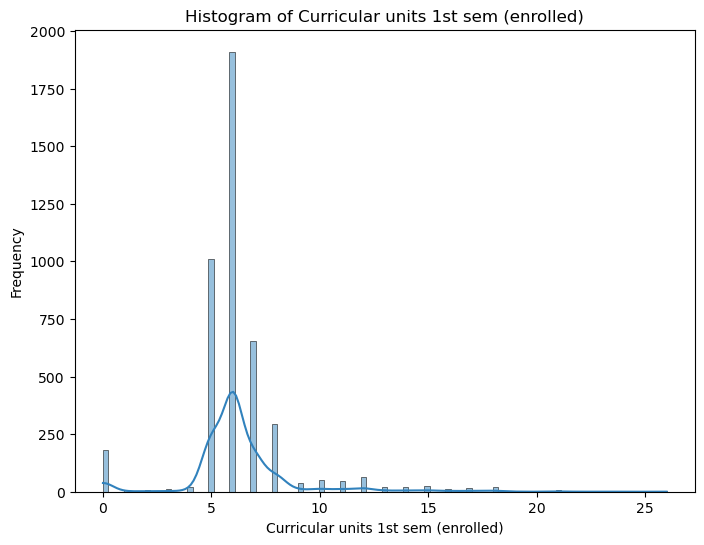

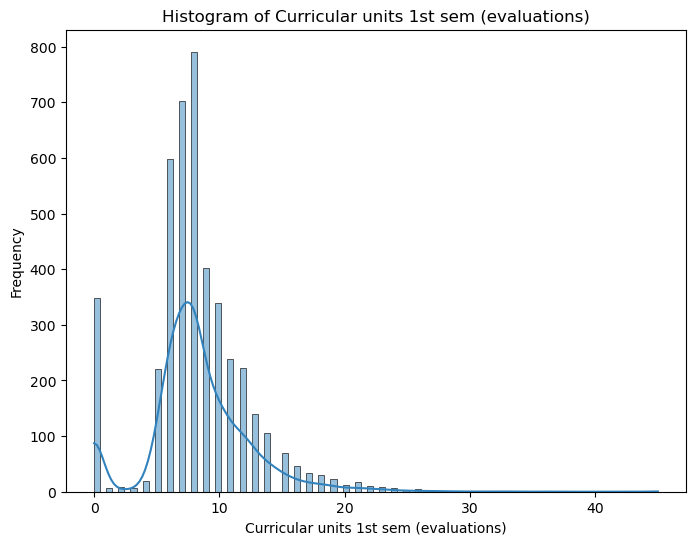

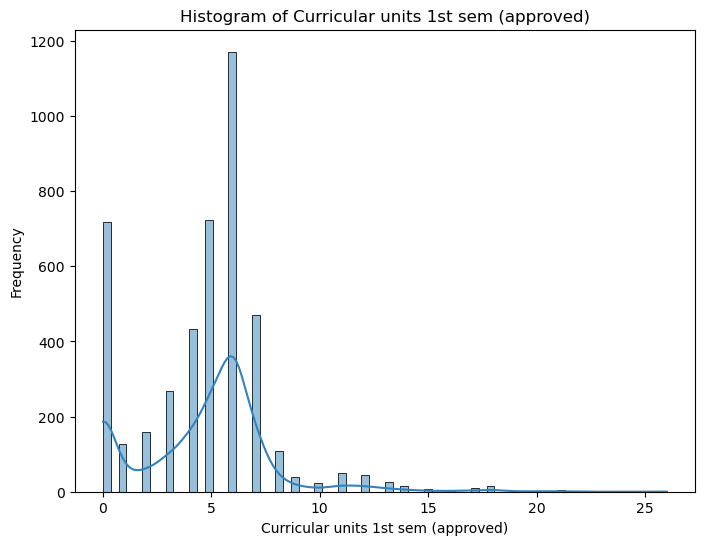

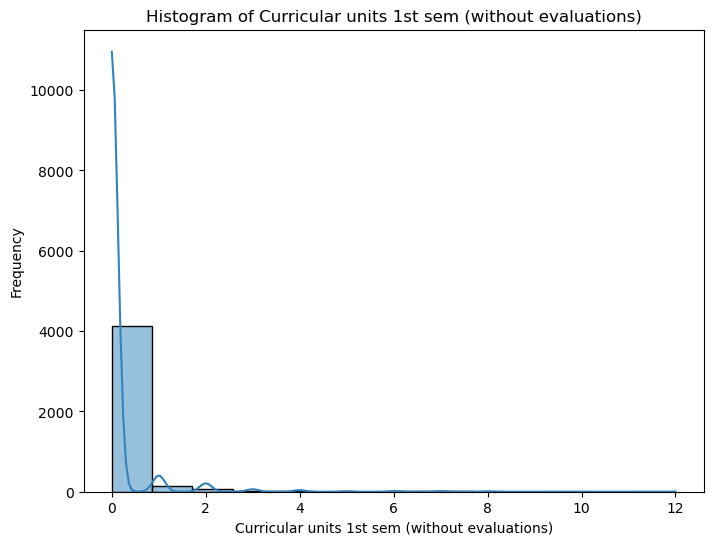

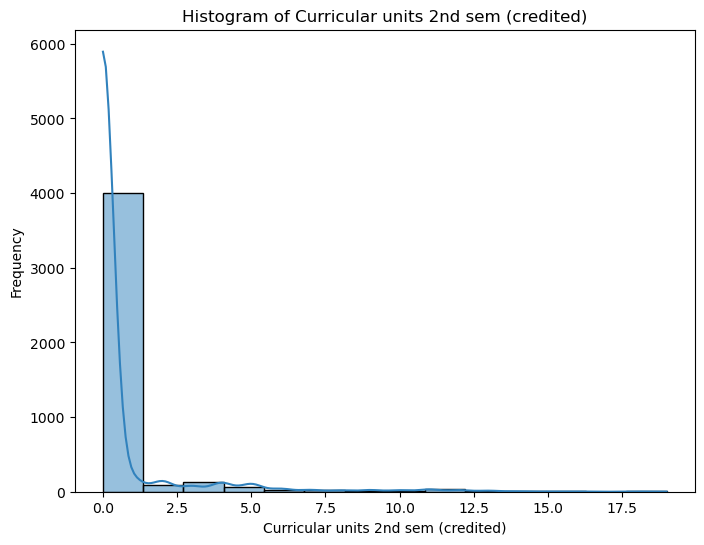

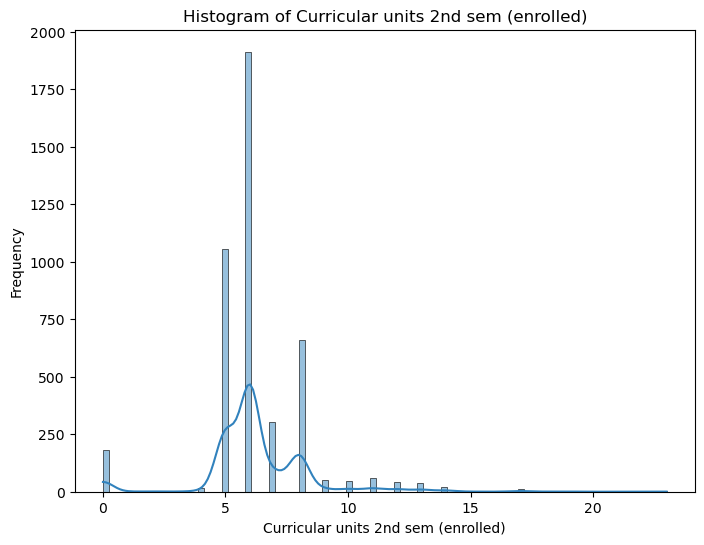

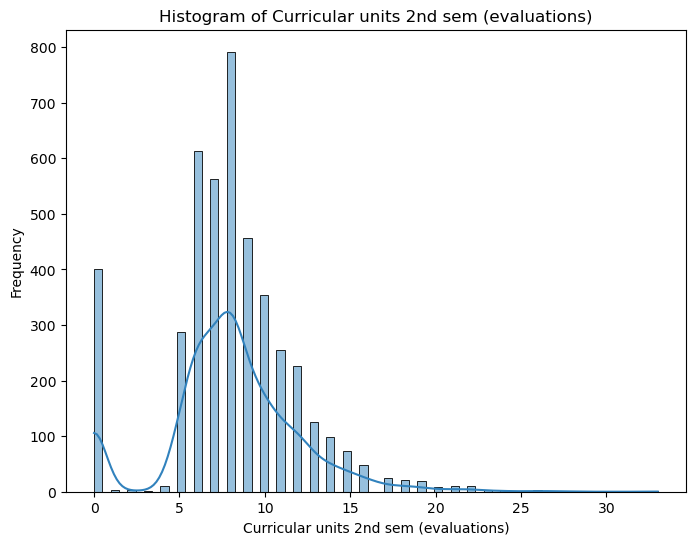

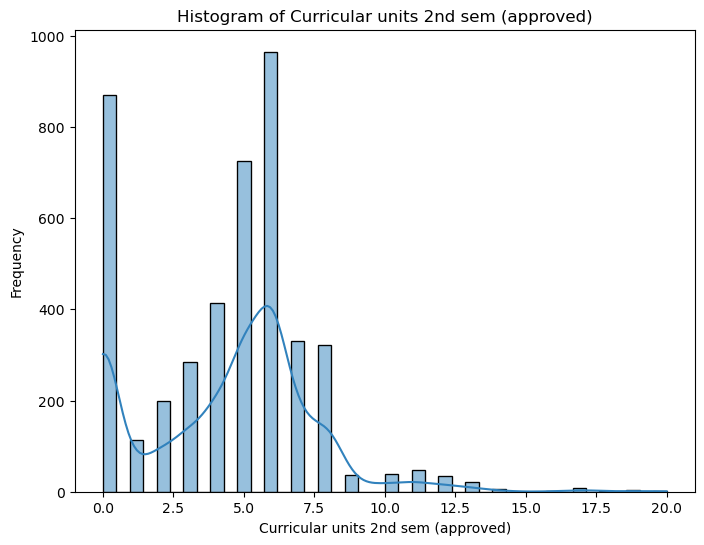

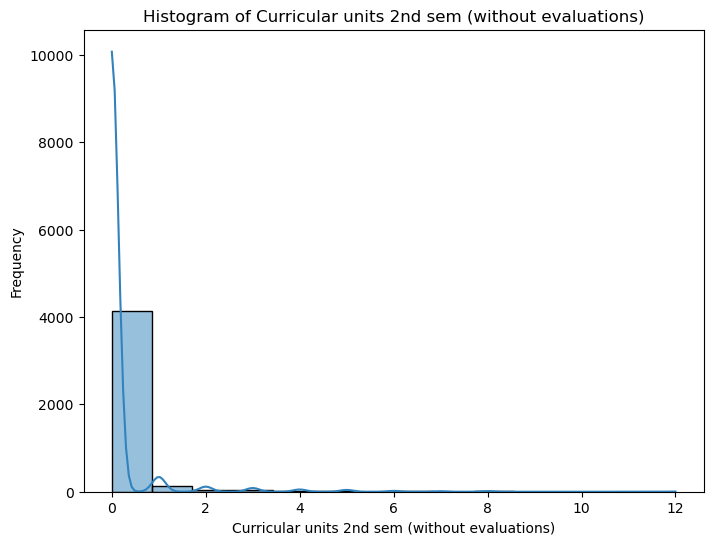

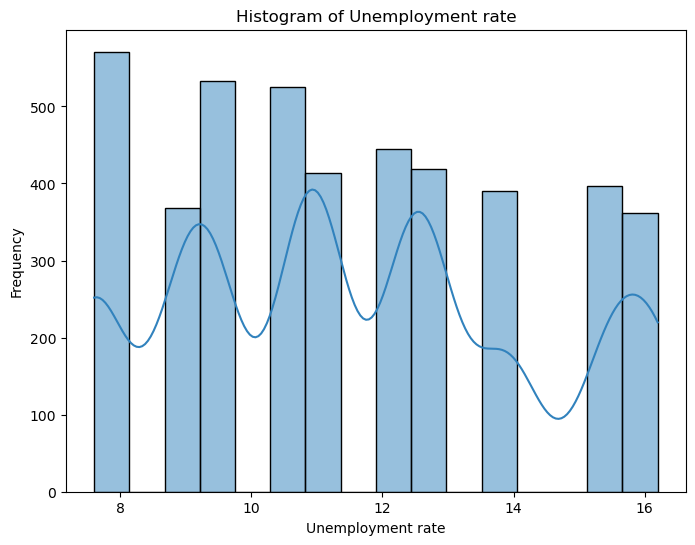

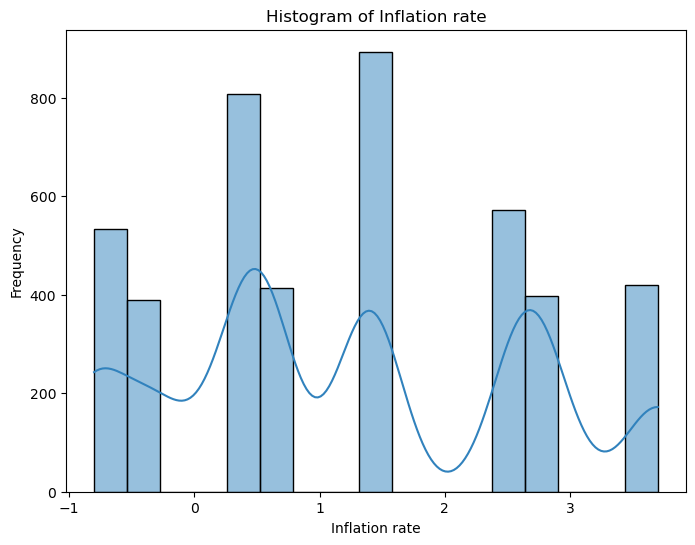

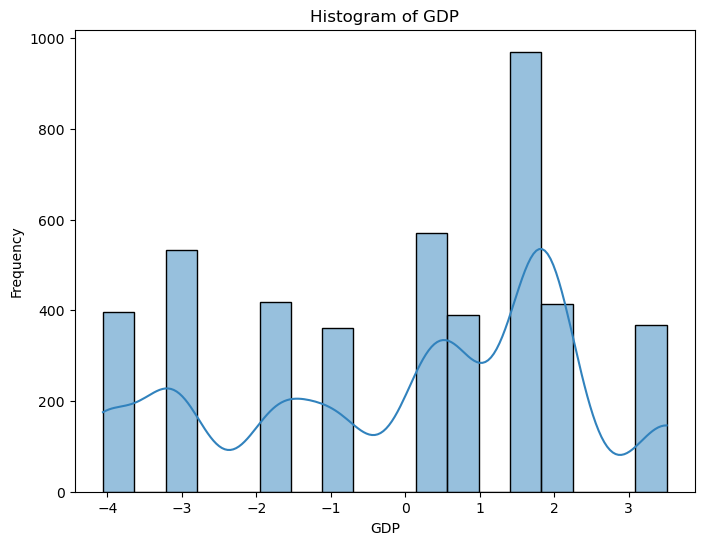

In [11]:
# Histogram for visualizing the distribution of a numerical variable:
def histograms(df):
    numerical_columns = df.select_dtypes(include = ["float", "int"]).columns
    for column in numerical_columns:
        plt.figure(figsize = (8, 6))
        custom_palette = ["#3182BD"]
        sns.set_palette(custom_palette)
        sns.histplot(df[column], kde = True)
        plt.title(f"Histogram of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

histograms(data)

## Data pre-processing

### Feature engineering

In [12]:
# Encoding target into numerical:
def encode_target(df, variable):
    category_order = ["Graduate", "Dropout", "Enrolled"]
    df[variable] = df[variable].astype("category").cat.set_categories(category_order)
    df[variable].replace({"Graduate": 0, "Dropout": 1, "Enrolled": 2}, inplace=True)
    return df

data = encode_target(data, "Target")

# Encoding strings into floats:
def encode_strings(df, variable):
    df[variable] = df[variable].str[:4].astype(float)
    return df

data = encode_strings(data, "Curricular units 1st sem (grade)")
data = encode_strings(data, "Curricular units 2nd sem (grade)")

# Encoding into subgroups (highly educated > secondary):
def encode_parents_qualification(df, mother_col, father_col, new_col):
    highly_educated_values = [2, 3, 4, 5, 6, 39, 40, 41, 42, 43, 44]
    df[new_col] = ((df[mother_col].isin(highly_educated_values)) | (df[father_col].isin(highly_educated_values))).astype(int).astype("category")
    df.drop(columns=[mother_col, father_col], inplace=True)
    return df

data = encode_parents_qualification(data, "Mother's qualification", "Father's qualification", "Parents' qualification")

# Rounding floating variables:
def rounding(df, variable):
    df[variable] = round(df[variable], 1)
    return df

data = rounding(data, "GDP")

### Cleaning data

In [13]:
# Zero columns:
def count_zeros(df):
    numerical_columns = df.select_dtypes(include = [np.number]).columns
    zeros_count = df[numerical_columns].eq(0).sum()
    return zeros_count

print(count_zeros(data))

# Dropping columns with zeroes:
def dropping(df, variable):
    df = df.drop(variable, axis = 1)
    return df

data = dropping(data, ["Curricular units 1st sem (credited)", "Curricular units 2nd sem (credited)", "Curricular units 1st sem (without evaluations)", "Curricular units 2nd sem (without evaluations)"])

# Removing outliers:
def remove_num_outliers(df):
    numerical_columns = df.select_dtypes(include = np.number).columns
    Q1 = df[numerical_columns].quantile(0.25)
    Q3 = df[numerical_columns].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df.copy()
    for column in numerical_columns:
        df_cleaned = df_cleaned[~((df_cleaned[column] < lower_bound[column]) | (df_cleaned[column] > upper_bound[column]))]
    return df_cleaned

data = remove_num_outliers(data)

Previous qualification (grade)                       0
Admission grade                                      0
Age at enrollment                                    0
Curricular units 1st sem (credited)               3847
Curricular units 1st sem (enrolled)                180
Curricular units 1st sem (evaluations)             349
Curricular units 1st sem (approved)                718
Curricular units 1st sem (grade)                   718
Curricular units 1st sem (without evaluations)    4130
Curricular units 2nd sem (credited)               3894
Curricular units 2nd sem (enrolled)                180
Curricular units 2nd sem (evaluations)             401
Curricular units 2nd sem (approved)                870
Curricular units 2nd sem (grade)                   870
Curricular units 2nd sem (without evaluations)    4142
Unemployment rate                                    0
Inflation rate                                       0
GDP                                                  0
dtype: int

### Feature selection

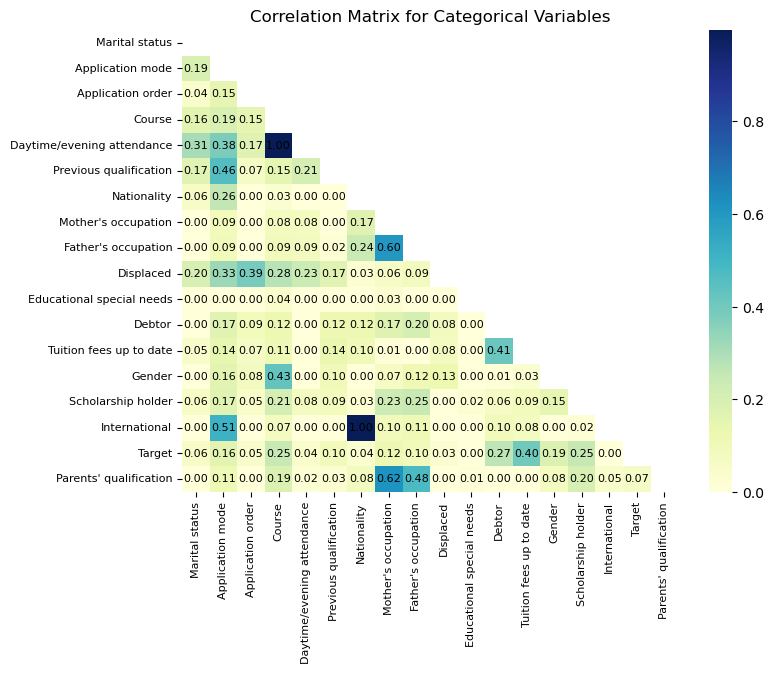

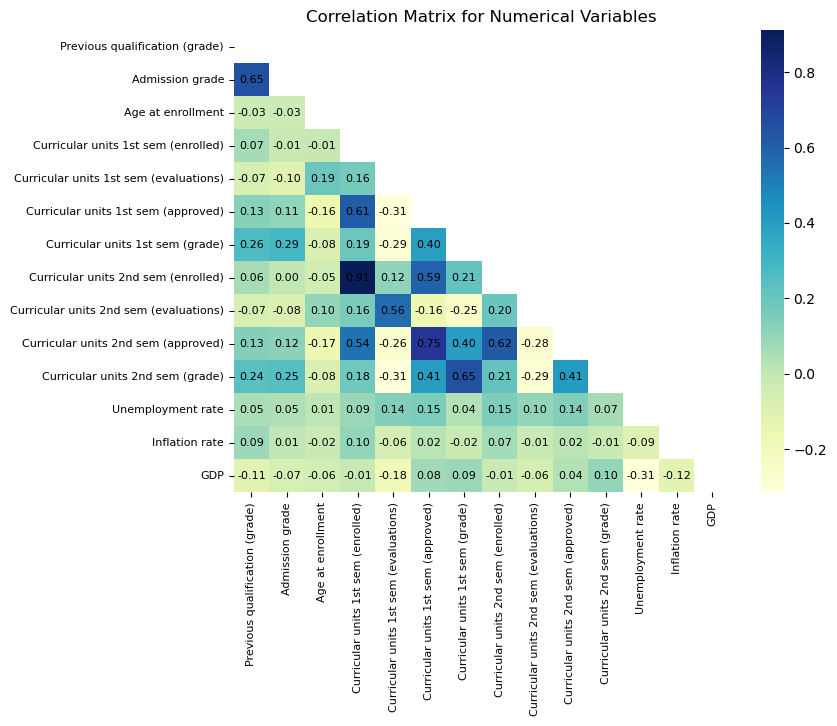

In [14]:
# Categorical correlation matrix: https://medium.com/@manindersingh120996/understanding-categorical-correlations-with-chi-square-test-and-cramers-v-a54fe153b1d6
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

def correlation_matrix_categorical(df):
    categorical_df = df.select_dtypes(include = ["category"])
    plt.figure(figsize = (8, 6))
    corr_matrix = pd.DataFrame(np.zeros((len(categorical_df.columns), len(categorical_df.columns))), 
                               index = categorical_df.columns, columns = categorical_df.columns)
    for i in range(len(categorical_df.columns)):
        for j in range(i, len(categorical_df.columns)):
            corr = cramers_v(categorical_df.iloc[:, i], categorical_df.iloc[:, j])
            corr_matrix.iloc[i, j] = corr
            corr_matrix.iloc[j, i] = corr
    mask = np.triu(np.ones_like(corr_matrix))
    heatmap = sns.heatmap(corr_matrix, cmap = "YlGnBu", mask = mask)
    # Add annotations manually
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            if not mask[i, j]:
                plt.text(j + 0.5, i + 0.5, "{:.2f}".format(corr_matrix.iloc[i, j]), 
                         ha = "center", va = "center", color = "black", fontsize = 8)
    plt.title("Correlation Matrix for Categorical Variables")
    heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize = 8)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize = 8)
    plt.show()
    
correlation_matrix_categorical(data)

# Numerical correlation matrix:
def correlation_matrix_numerical(df):
    numerical_df = df.select_dtypes(include = ['float64', 'int64'])
    plt.figure(figsize = (8, 6))
    mask = np.triu(np.ones_like(numerical_df.corr()))
    heatmap = sns.heatmap(numerical_df.corr(), cmap = "YlGnBu", mask = mask)
    # Add annotations manually
    for i in range(len(numerical_df.columns)):
        for j in range(len(numerical_df.columns)):
            if not mask[i, j]:
                plt.text(j + 0.5, i + 0.5, "{:.2f}".format(numerical_df.corr().iloc[i, j]),
                         ha = "center", va = "center", color = "black", fontsize = 8)
    plt.title("Correlation Matrix for Numerical Variables")
    heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize = 8)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize = 8)
    plt.show()

correlation_matrix_numerical(data)

# Dropping variables > 0.7 correlation:
data = dropping(data, ["Nationality", "Daytime/evening attendance", "Curricular units 1st sem (enrolled)", "Curricular units 1st sem (approved)"])

## EDA Part 2

In [15]:
data

,Marital status,Application mode,Application order,Course,Previous qualification,Previous qualification (grade),Mother's occupation,Father's occupation,Admission grade,Displaced,...,Curricular units 1st sem (grade),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Unemployment rate,Inflation rate,GDP,Target,Parents' qualification
1,1,15,1,9254,1,160.0,3,3,142.5,1,...,14.0,6,6,6,13.6,13.9,-0.3,0.8,0,1
3,1,17,2,9773,1,122.0,5,3,119.6,1,...,13.4,6,10,5,12.4,9.4,-0.8,-3.1,0,0
6,1,1,1,9500,1,142.0,7,10,128.4,1,...,13.3,8,8,8,14.3,15.5,2.8,-4.1,0,0
8,1,1,3,9238,1,137.0,9,9,129.3,0,...,13.8,6,7,6,14.1,16.2,0.3,-0.9,0,0
9,1,1,1,9238,1,138.0,4,7,123.0,1,...,11.4,6,14,2,13.5,8.9,1.4,3.5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4417,1,1,1,9070,1,132.0,9,9,133.8,1,...,13.8,6,6,6,13.5,16.2,0.3,-0.9,0,0
4418,1,44,1,9070,39,120.0,3,9,120.0,0,...,12.5,9,10,7,13.1,16.2,0.3,-0.9,0,1
4419,1,1,6,9773,1,125.0,5,4,122.2,0,...,13.6,6,8,5,12.6,15.5,2.8,-4.1,0,0
4420,1,1,2,9773,1,120.0,9,9,119.0,1,...,12.0,6,6,2,11.0,11.1,0.6,2.0,1,0


In [16]:
# Shape:
data.shape

(2638, 28)

In [17]:
# Features:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2638 entries, 1 to 4423
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   Marital status                          2638 non-null   category
 1   Application mode                        2638 non-null   category
 2   Application order                       2638 non-null   category
 3   Course                                  2638 non-null   category
 4   Previous qualification                  2638 non-null   category
 5   Previous qualification (grade)          2638 non-null   float64 
 6   Mother's occupation                     2638 non-null   category
 7   Father's occupation                     2638 non-null   category
 8   Admission grade                         2638 non-null   float64 
 9   Displaced                               2638 non-null   category
 10  Educational special needs               2638 non

In [18]:
# Imbalance:
def data_distribution (df, target): 
    graduated = round(len(df[df[target] == 0]) / len(df) * 100, 2)
    dropped = round(len(df[df[target] == 1]) / len(df) * 100, 2)
    enrolled = round(len(df[df[target] == 2]) / len(df) * 100, 2)
    return graduated, dropped, enrolled
    
data_distribution(data, "Target")

(59.67, 18.57, 21.76)

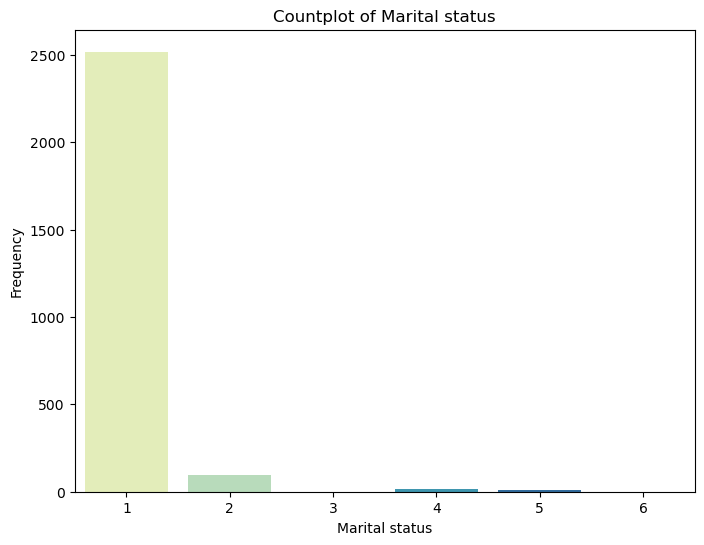

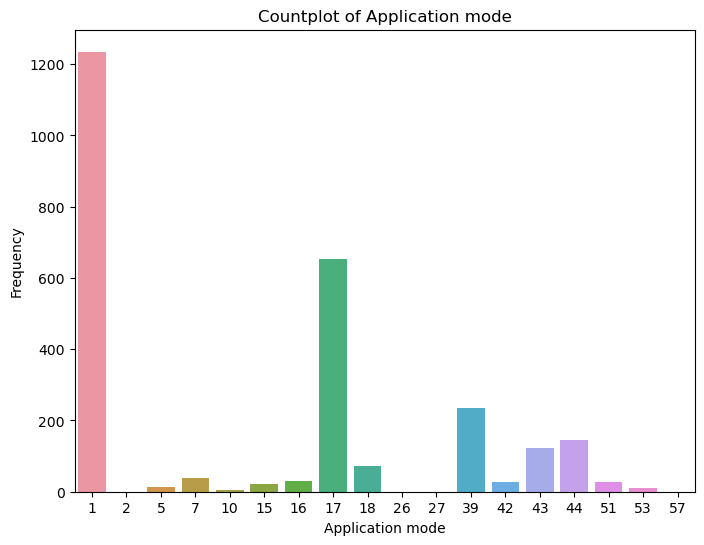

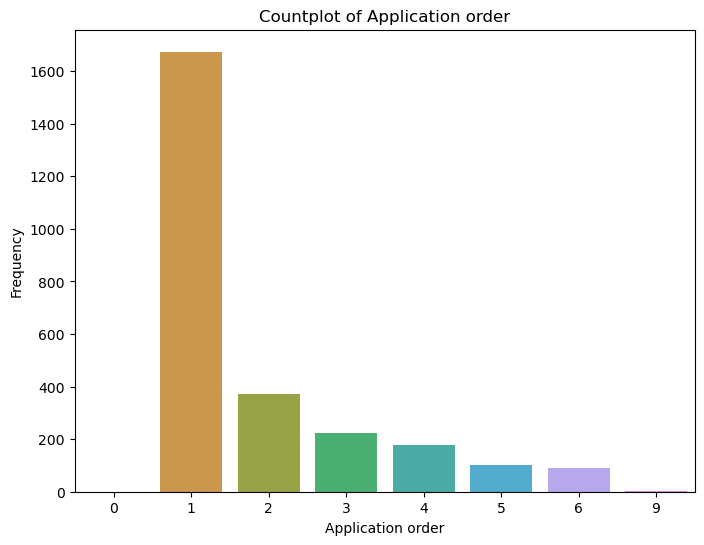

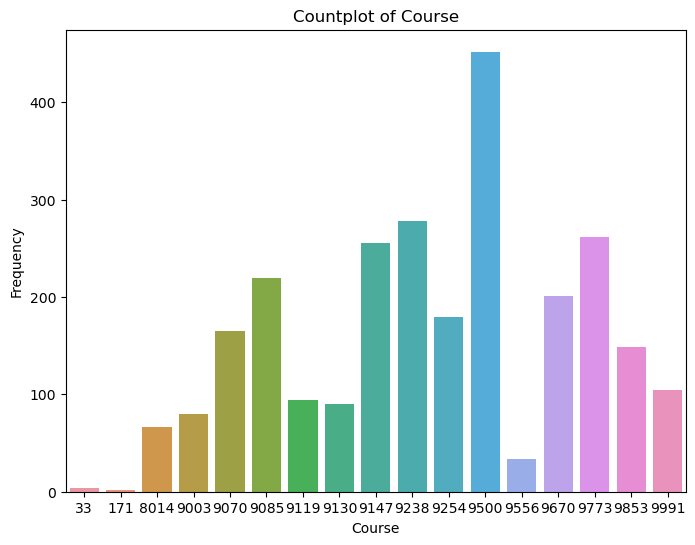

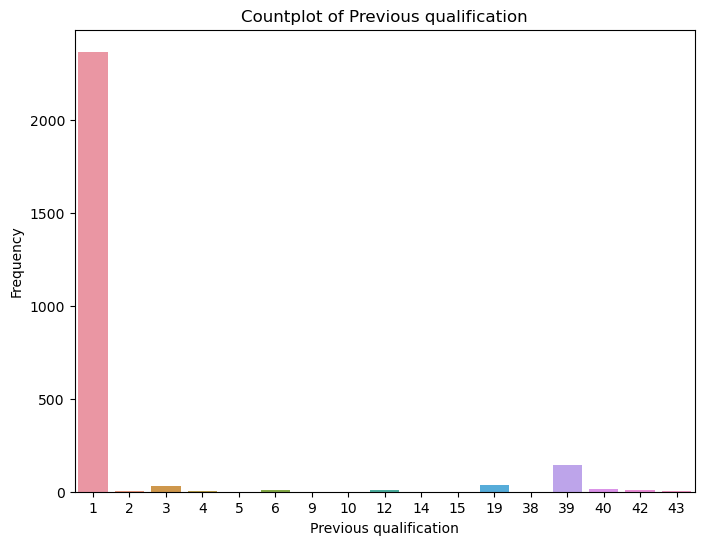

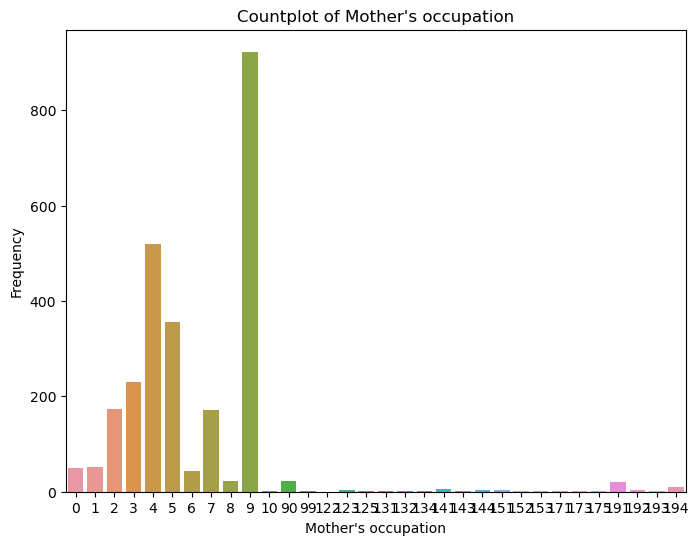

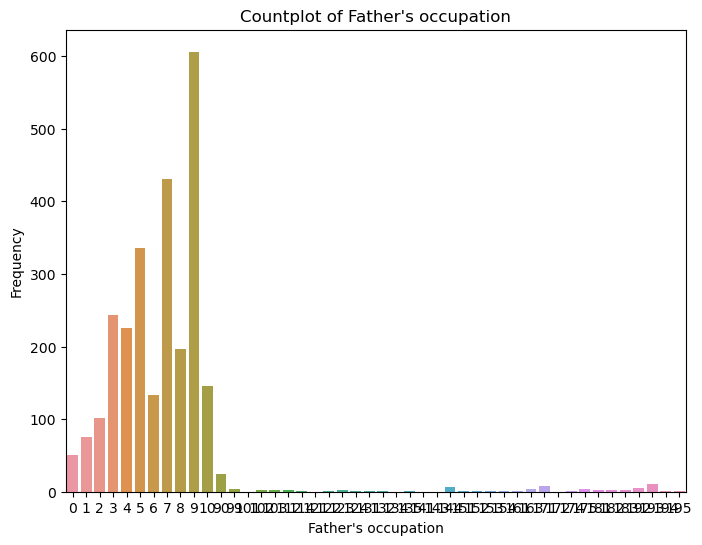

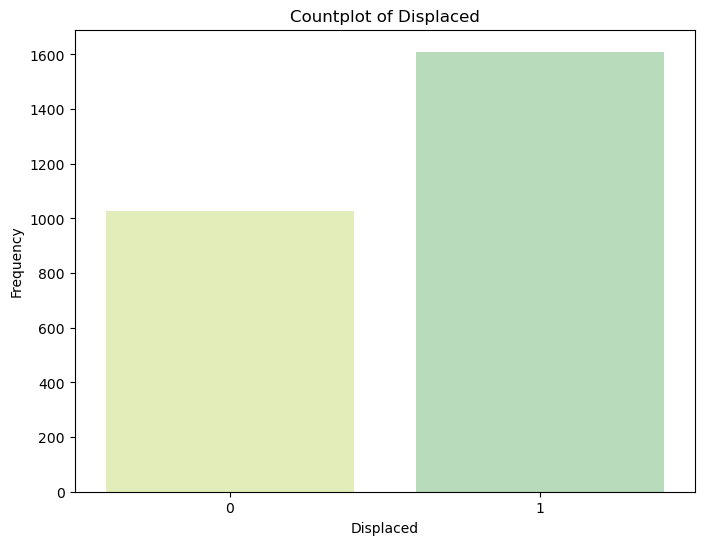

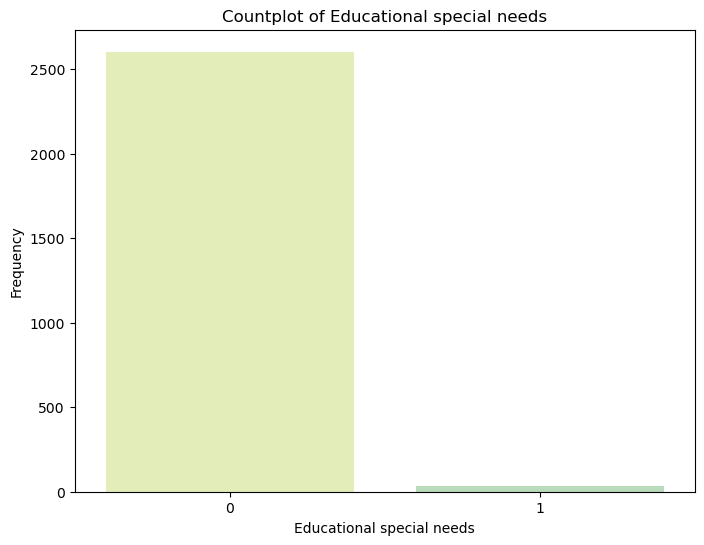

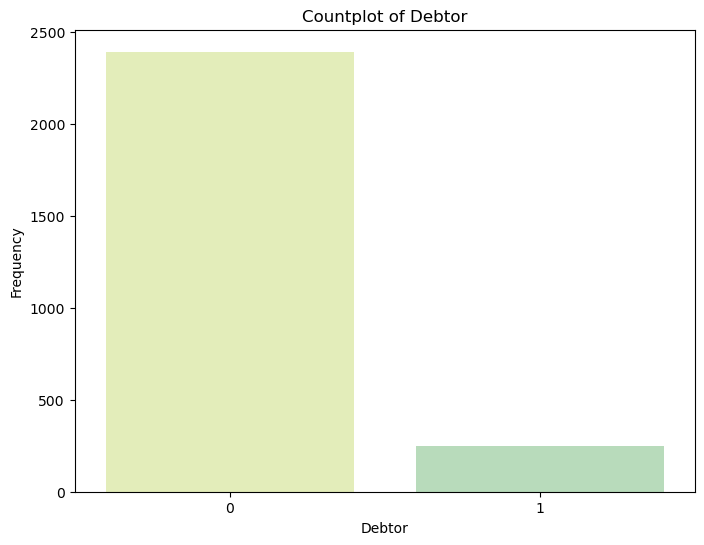

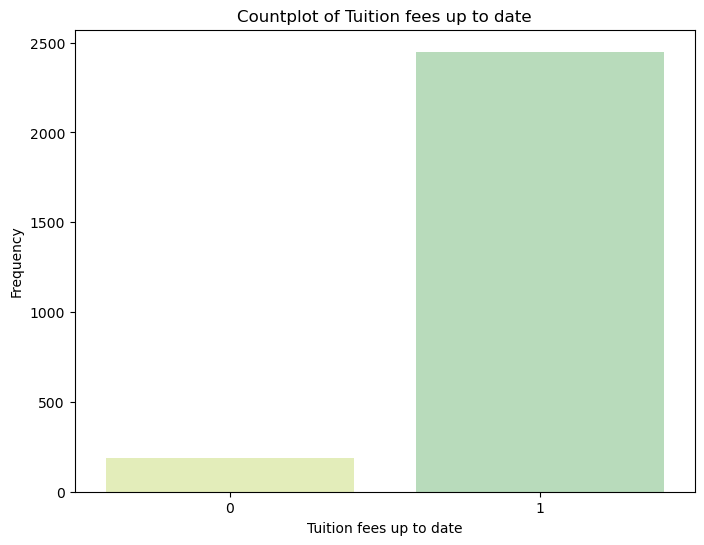

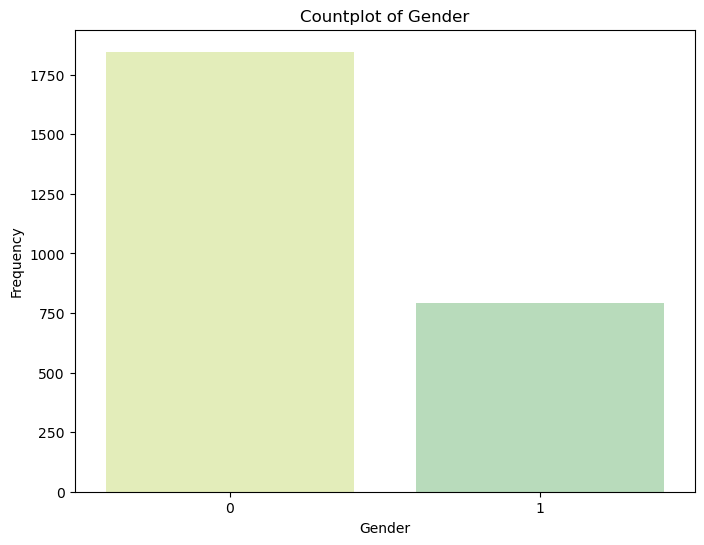

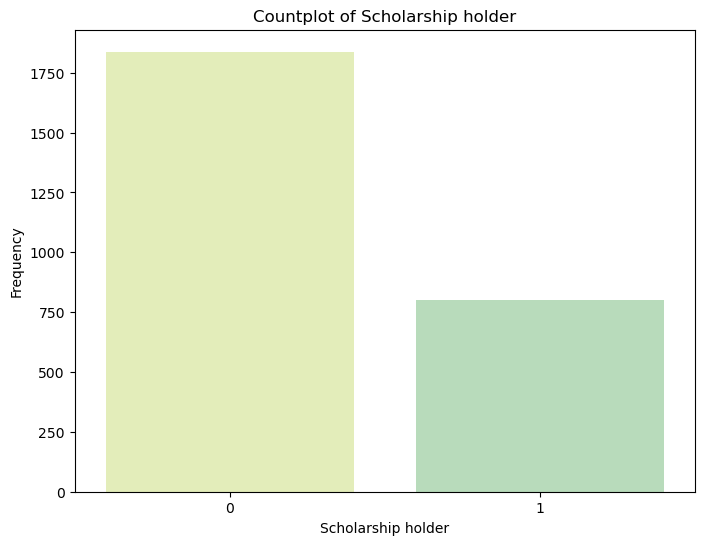

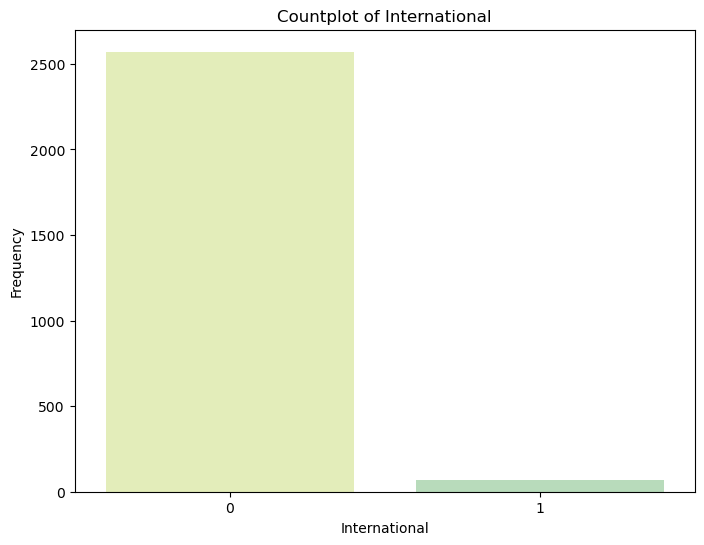

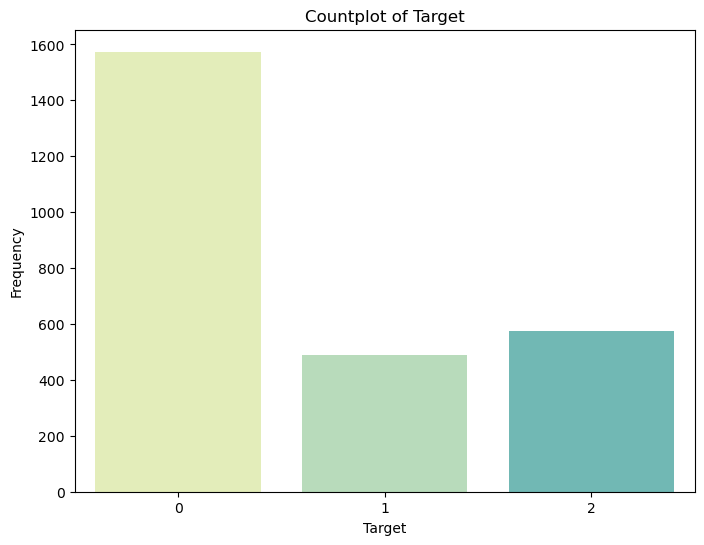

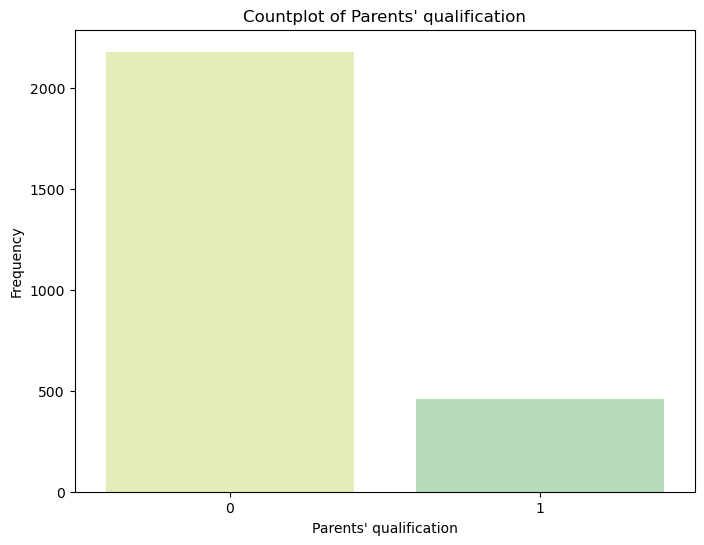

In [19]:
# Countplot for visualizing the frequency of categories in a categorical variable
def countplots(df):
    categorical_columns = df.select_dtypes(include = ["category"]).columns
    for column in categorical_columns:
        plt.figure(figsize = (8, 6))
        sns.set_palette("YlGnBu")
        order = df[column].cat.categories
        sns.countplot(x = column, data = df, order = order)
        plt.title(f"Countplot of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

countplots(data)

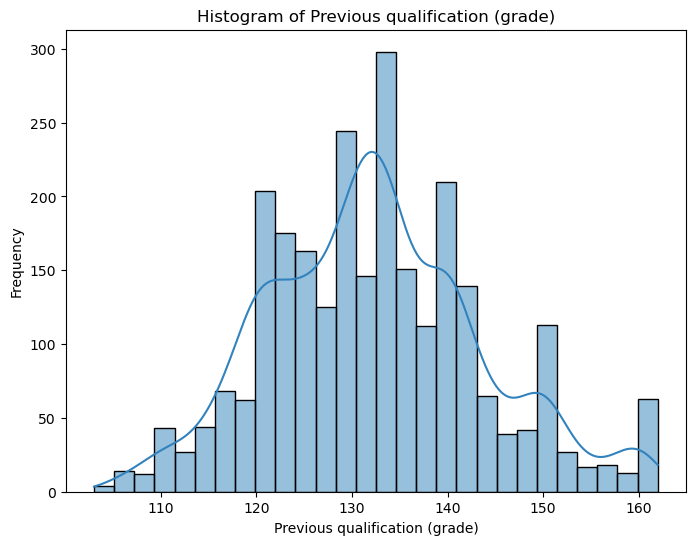

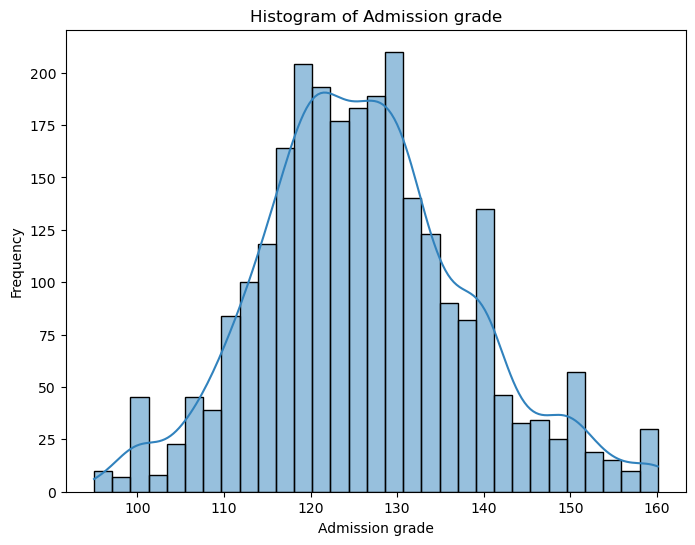

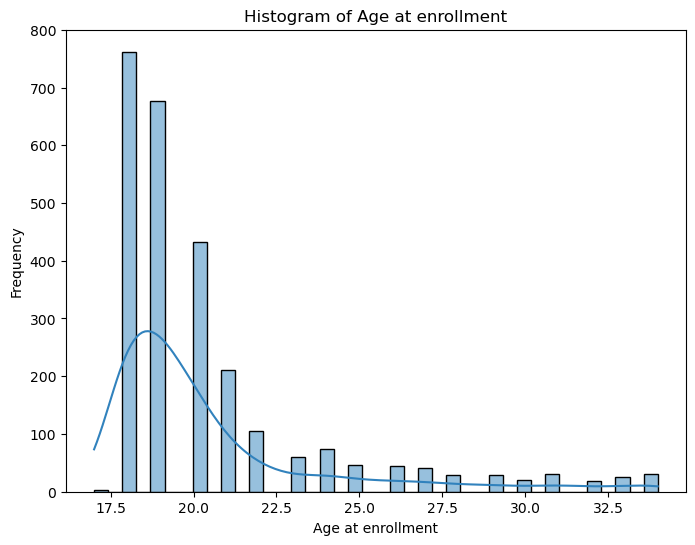

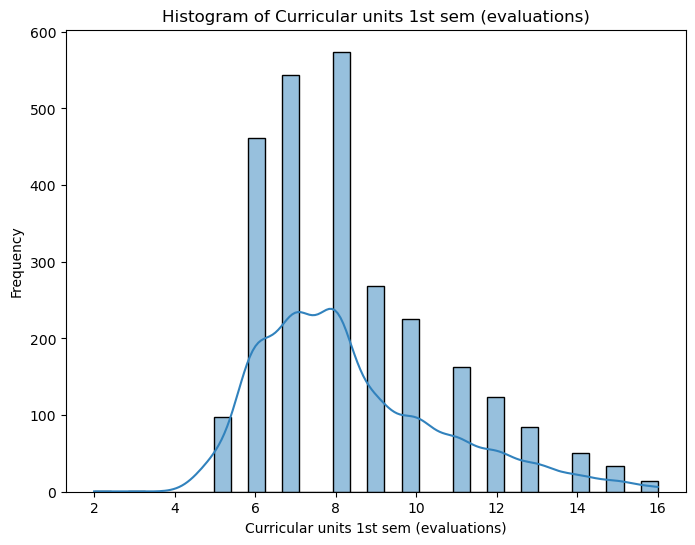

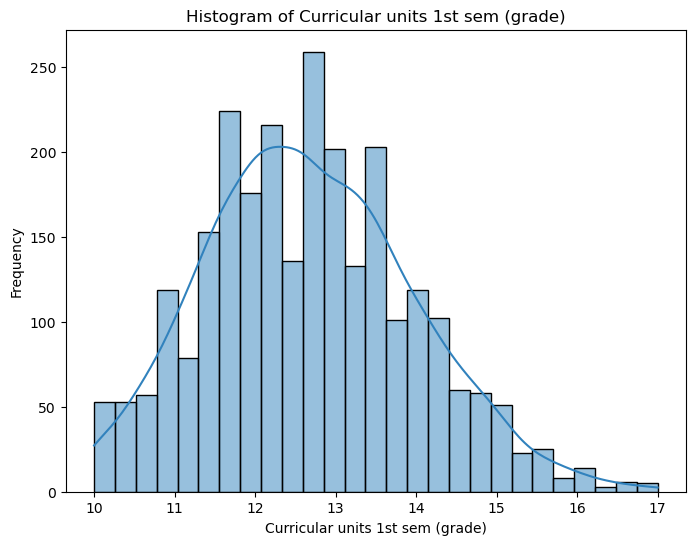

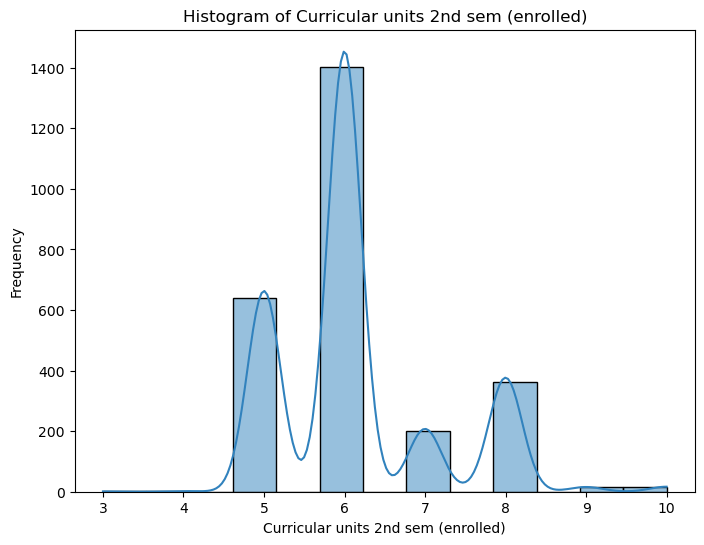

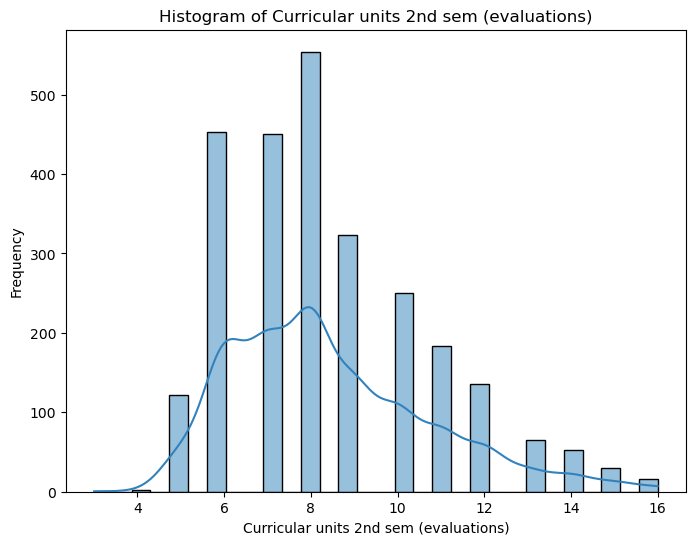

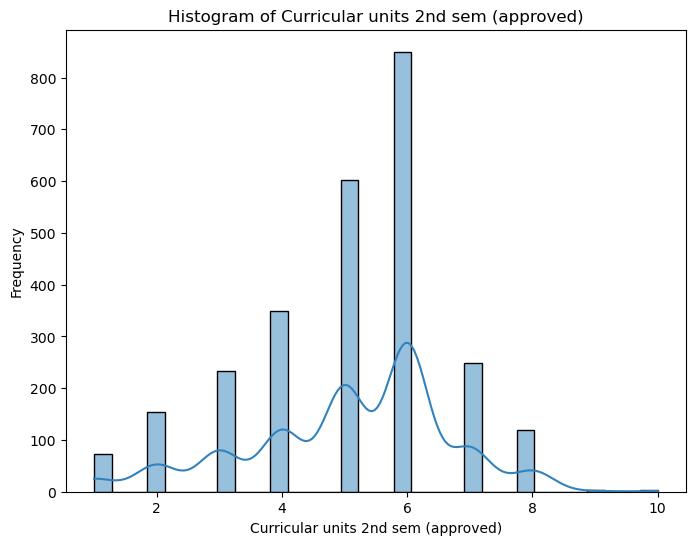

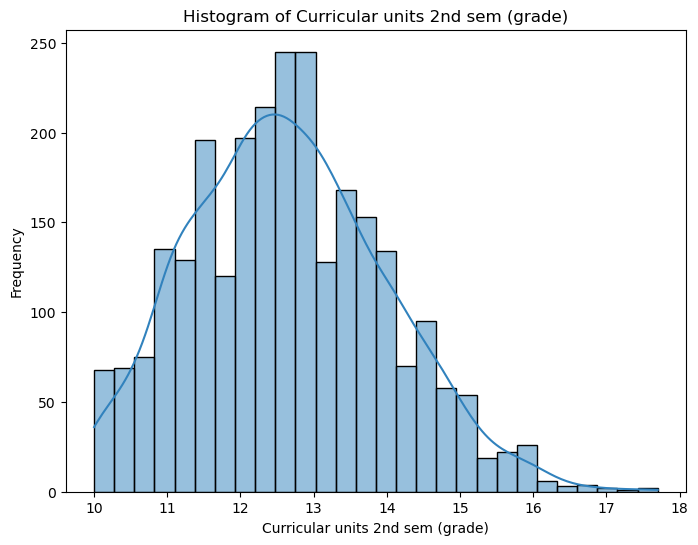

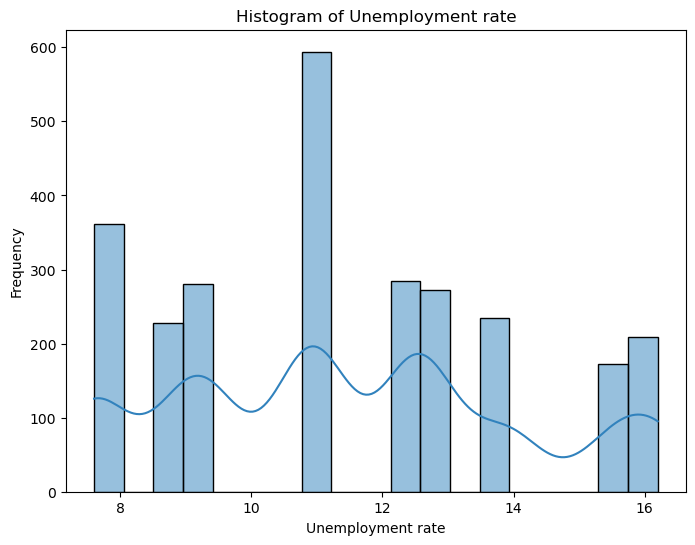

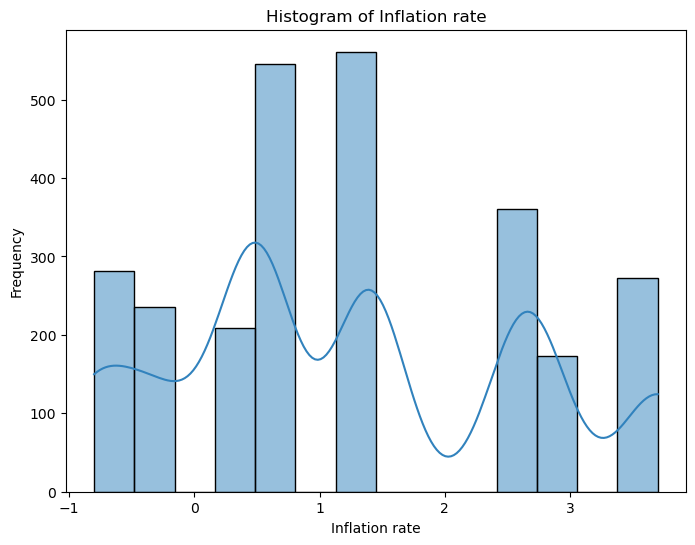

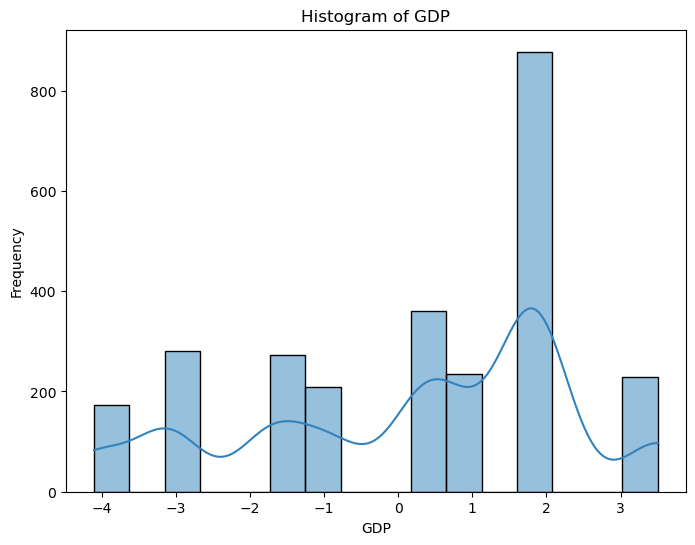

In [20]:
# Histogram for visualizing the distribution of a numerical variable:
def histograms(df):
    numerical_columns = df.select_dtypes(include = ["float", "int"]).columns
    for column in numerical_columns:
        plt.figure(figsize = (8, 6))
        custom_palette = ["#3182BD"]
        sns.set_palette(custom_palette)
        sns.histplot(df[column], kde = True)
        plt.title(f"Histogram of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

histograms(data)

## Splitting data

In [21]:
# Splitting into train/test:
def split_data(df):
    train, test = train_test_split(df, test_size = 0.2, random_state = seed_value)
    train.reset_index(drop = True, inplace = True)
    test.reset_index(drop = True, inplace = True)
    return train, test

train, test = split_data(data)

In [22]:
# Splitting variables:
def split_variables(df, target):
    X = df.drop(target, axis = 1)
    y = df[target]
    return X, y

X_train, y_train = split_variables(train, "Target")
X_test, y_test = split_variables(test, "Target")

In [23]:
# One-hot encoding categorical variables:
def one_hot_encode(df):
    categorical_cols = df.select_dtypes(include = ["category"]).columns.tolist()
    for column in categorical_cols:
        encoded_cols = pd.get_dummies(df[column], prefix = column, prefix_sep = "_")
        encoded_cols = encoded_cols.astype(int)
        df = pd.concat([df.drop(column, axis = 1), encoded_cols], axis = 1)
    return df

X_train = one_hot_encode(X_train)
X_test = one_hot_encode(X_test)

In [24]:
# Hyperparameter tuning with SMOTE and cross-validation (https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html):
def hyperparameter_tuning(model, param_grid):
    f1_scorer = make_scorer(f1_score, average = "macro")
    skf = StratifiedKFold(n_splits = 5, random_state = seed_value, shuffle = True)
    pipeline = make_pipeline(SMOTE(random_state = seed_value), model)
    new_params = {"{0}__{1}".format(model.__class__.__name__.lower(), key): value for key, value in param_grid.items()}
    random_search = RandomizedSearchCV(pipeline, param_distributions = new_params, cv = skf, error_score = "raise", 
                                       scoring = f1_scorer, return_train_score = True, random_state = seed_value)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    return best_model, best_params, best_score

## Building models

### Model 1 - XGBoost (baseline)

In [25]:
xgb_model = XGBClassifier() # https://www.sciencedirect.com/science/article/pii/S2214716023000271

param_grid_xgb = {"max_depth": [5, 6, 7, 8, 9],
                  "n_estimators": list(range(200, 301, 10)),
                  "learning_rate": [0.1, 0.05, 0.02, 0.01],
                  "reg_alpha": [0.075, 0.1, 0.125, 0.15],
                  "reg_lambda": [0.2, 0.25, 0.3, 0.5]}

best_model_xgb, best_params_xgb, best_score_xgb = hyperparameter_tuning(xgb_model, param_grid_xgb)

print(best_model_xgb)
print(best_params_xgb)
print(best_score_xgb)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strat

### Model 2 - ANN

In [26]:
ann_model = MLPClassifier() # https://www.sciencedirect.com/science/article/pii/S2666920X21000126?via%3Dihub

param_grid_ann = {"hidden_layer_sizes": [(50, )],
                  "activation": ["tanh"],
                  "solver": ["sgd", "adam"],
                  "learning_rate_init": [0.001, 0.0005, 0.0001, 0.00005, 0.00001],
                  "momentum": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                  "max_iter": [3000, 5000, 10000],
                  "verbose": [False],
                  "early_stopping": [False],
                  "n_iter_no_change": [10]}

best_model_ann, best_params_ann, best_score_ann = hyperparameter_tuning(ann_model, param_grid_ann)

print(best_model_ann)
print(best_params_ann)
print(best_score_ann)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(50,),
                               learning_rate_init=1e-05, max_iter=10000,
                               momentum=0.1))])
{'mlpclassifier__verbose': False, 'mlpclassifier__solver': 'adam', 'mlpclassifier__n_iter_no_change': 10, 'mlpclassifier__momentum': 0.1, 'mlpclassifier__max_iter': 10000, 'mlpclassifier__learning_rate_init': 1e-05, 'mlpclassifier__hidden_layer_sizes': (50,), 'mlpclassifier__early_stopping': False, 'mlpclassifier__activation': 'tanh'}
0.6267785646680211


### Model 3 - Voting (NB, DT, SVM, and KNN)

In [27]:
# NB classifier:
nb_classifier = GaussianNB() # https://ieeexplore.ieee.org/document/10082724

param_grid_nb = {"var_smoothing": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.1, 1, 10, 100, 1000]}

best_model_nb, best_params_nb, best_score_nb = hyperparameter_tuning(nb_classifier, param_grid_nb)

print(best_model_nb)
print(best_params_nb)
print(best_score_nb)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('gaussiannb', GaussianNB(var_smoothing=0.0001))])
{'gaussiannb__var_smoothing': 0.0001}
0.5604630691346864


In [28]:
# DT classifier:
dt_classifier = DecisionTreeClassifier() # https://ieeexplore.ieee.org/document/10349050

param_grid_dt = {"criterion": ["gini", "entropy"],
                 "max_depth": [None, 10, 20, 30, 40, 50],
                 "min_samples_split": [2, 5, 10, 20, 30, 50],
                 "min_samples_leaf": [1, 2, 4, 8, 10, 20]}

best_model_dt, best_params_dt, best_score_dt = hyperparameter_tuning(dt_classifier, param_grid_dt)

print(best_model_dt)
print(best_params_dt)
print(best_score_dt)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        min_samples_leaf=8,
                                        min_samples_split=30))])
{'decisiontreeclassifier__min_samples_split': 30, 'decisiontreeclassifier__min_samples_leaf': 8, 'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__criterion': 'entropy'}
0.5625614271185082


In [29]:
# SVM classifier:
svm_classifier = SVC(probability = True) # https://ieeexplore.ieee.org/document/9065509 / https://ieeexplore.ieee.org/document/10082724

param_grid_svm = {"kernel": ["linear", "rbf", "sigmoid"],
                  "C": [0.01, 0.1, 1], 
                  "gamma": [0.001, 0.01, 0.1, 1]}

best_model_svm, best_params_svm, best_score_svm = hyperparameter_tuning(svm_classifier, param_grid_svm)

print(best_model_svm)
print(best_params_svm)
print(best_score_svm)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('svc',
                 SVC(C=1, gamma=0.1, kernel='linear', probability=True))])
{'svc__kernel': 'linear', 'svc__gamma': 0.1, 'svc__C': 1}
0.6244376841012873


In [30]:
# KNN classifier:
knn_classifier = KNeighborsClassifier() # https://ieeexplore.ieee.org/document/10349050

param_grid_knn = {"n_neighbors": list(range(3, 102, 2)),
                  "weights": ["uniform", "distance"],
                  "metric": ["euclidean", "manhattan"],
                  "leaf_size": list(range(10, 100, 10))}

best_model_knn, best_params_knn, best_score_knn = hyperparameter_tuning(knn_classifier, param_grid_knn)

print(best_model_knn)
print(best_params_knn)
print(best_score_knn)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(leaf_size=50, metric='manhattan',
                                      n_neighbors=75, weights='distance'))])
{'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 75, 'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__leaf_size': 50}
0.49889044456928194


In [31]:
vt_model = VotingClassifier(estimators = [("nb", best_model_nb), ("dt", best_model_dt), 
                                          ("svm", best_model_svm), ("knn", best_model_knn)],
                           voting = "soft") # https://www.researchgate.net/publication/361101272_Utilization_of_Ensemble_Techniques_for_Prediction_of_the_Academic_Performance_of_Students

param_grid_vt = {"weights": [[1, 1, 1, 1], [2, 1, 1, 1], [1, 2, 1, 1], [1, 1, 2, 1], [1, 1, 1, 2], [2, 2, 1, 1],
                             [2, 1, 2, 1], [2, 1, 1, 2], [1, 2, 2, 1], [1, 2, 1, 2], [1, 1, 2, 2], [2, 2, 2, 1],
                             [2, 2, 1, 2], [2, 1, 2, 2], [1, 2, 2, 2], [2, 2, 2, 2]]}

best_model_vt, best_params_vt, best_score_vt = hyperparameter_tuning(vt_model, param_grid_vt)

print(best_model_vt)
print(best_params_vt)
print(best_score_vt)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('votingclassifier',
                 VotingClassifier(estimators=[('nb',
                                               Pipeline(steps=[('smote',
                                                                SMOTE(random_state=101)),
                                                               ('gaussiannb',
                                                                GaussianNB(var_smoothing=0.0001))])),
                                              ('dt',
                                               Pipeline(steps=[('smote',
                                                                SMOTE(random_state=101)),
                                                               ('decisiontreeclassifier',
                                                                DecisionTreeClassifier(criterion='entropy',
                                                                                       max_depth=10,


### Model 4 - Stacking (RF, XGBoost, GB, and FNN)

In [32]:
# RF classifier:
rf_classifier = RandomForestClassifier() # https://link.springer.com/article/10.1007/s10462-020-09896-5#Tab2

param_grid_rf = {"n_estimators": [50, 100, 200],
                 "max_depth": [5, 8, 10],
                 "min_samples_split": [2, 5, 10, 20],
                 "min_samples_leaf": [1, 25, 50, 70],
                 "max_features": ["log2", "sqrt", 0.25, 1]}

best_model_rf, best_params_rf, best_score_rf = hyperparameter_tuning(rf_classifier, param_grid_rf)

print(best_model_rf)
print(best_params_rf)
print(best_score_rf)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, max_features=0.25,
                                        min_samples_split=5,
                                        n_estimators=200))])
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 0.25, 'randomforestclassifier__max_depth': 10}
0.636557690658897


In [33]:
# XGB classifier:
print(best_model_xgb)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strat

In [34]:
# GB classifier: 
gb_classifier = GradientBoostingClassifier() # https://link.springer.com/article/10.1007/s10462-020-09896-5#Tab2

param_grid_gb = {"n_estimators": [50, 100, 200],
                    "learning_rate": [0.025, 0.05, 0.1, 0.2, 0.3], 
                    "max_depth": [2, 3, 5, 7, 10],
                    "min_samples_split": [2, 5, 10, 20],
                    "max_features": ["log2", "sqrt", 0.25, 1],
                    "subsample": [0.15, 0.5, 0.75, 1]}

best_model_gb, best_params_gb, best_score_gb = hyperparameter_tuning(gb_classifier, param_grid_gb)

print(best_model_gb)
print(best_params_gb)
print(best_score_gb)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.025, max_depth=7,
                                            max_features='log2',
                                            min_samples_split=5,
                                            n_estimators=200, subsample=1))])
{'gradientboostingclassifier__subsample': 1, 'gradientboostingclassifier__n_estimators': 200, 'gradientboostingclassifier__min_samples_split': 5, 'gradientboostingclassifier__max_features': 'log2', 'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__learning_rate': 0.025}
0.638077330173308


In [35]:
# FNN classifier:
print(best_model_ann)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(50,),
                               learning_rate_init=1e-05, max_iter=10000,
                               momentum=0.1))])


In [36]:
st_model = StackingClassifier(estimators = [("rf", best_model_rf), ("xgb", best_model_xgb), ("gb", best_model_gb)], 
                              final_estimator = best_model_ann) # https://www.sciencedirect.com/science/article/pii/S2666920X22000212

param_grid_st = {"stack_method": ["auto", "predict_proba"],
                 "passthrough": [True, False]}

best_model_st, best_params_st, best_score_st = hyperparameter_tuning(st_model, param_grid_st)

print(best_model_st)
print(best_params_st)
print(best_score_st)

C:\Users\yase_\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('stackingclassifier',
                 StackingClassifier(estimators=[('rf',
                                                 Pipeline(steps=[('smote',
                                                                  SMOTE(random_state=101)),
                                                                 ('randomforestclassifier',
                                                                  RandomForestClassifier(max_depth=10,
                                                                                         max_features=0.25,
                                                                                         min_samples_split=5,
                                                                                         n_estimators=200))])),
                                                ('xgb',
                                                 Pipeline(steps=[('smote',
                               

## Model Comparison

In [37]:
# F1 scores on training:
print("F1 score training xgb:", best_score_xgb)
print("F1 score training ann:", best_score_ann)
print("F1 score training vt:", best_score_vt)
print("F1 score training st:", best_score_st)

F1 score training xgb: 0.6288908343984746
F1 score training ann: 0.6267785646680211
F1 score training vt: 0.6309953388998915
F1 score training st: 0.6411608297475532


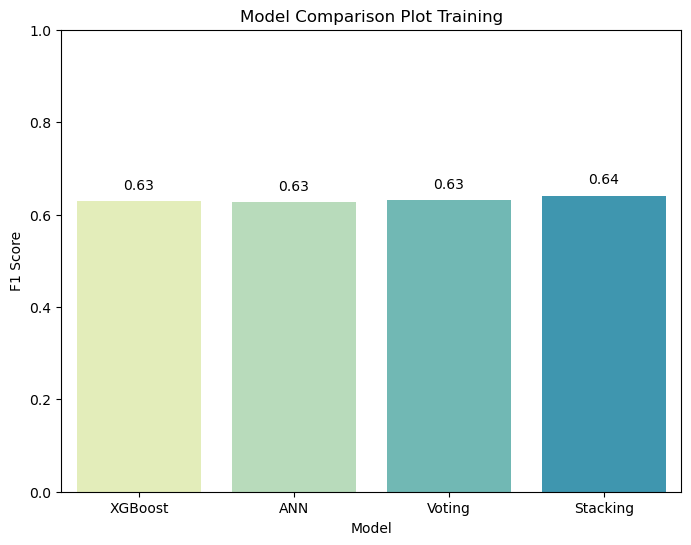

In [51]:
# Visualization model comparison training:
def barplot_models(model_scores):
    model_names = list(model_scores.keys())
    f1_scores = list(model_scores.values())
    plt.figure(figsize = (8, 6))
    sns.set_palette("YlGnBu")
    bars = sns.barplot(x = model_names, y = f1_scores)
    plt.title("Model Comparison Plot Training")
    plt.xlabel("Model")
    plt.ylabel("F1 Score")
    plt.ylim(0, 1)
    for bar, f1_score in zip(bars.patches, f1_scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{f1_score:.2f}", ha = "center", va = "bottom")
    plt.show()

barplot_models(model_scores = {"XGBoost": best_score_xgb, "ANN": best_score_ann, "Voting": best_score_vt, "Stacking": best_score_st})

In [39]:
# Predictions:
def f1_models(best_model):
    y_pred = best_model.predict(X_test)
    y_true = y_test
    f1 = f1_score(y_true, y_pred, average = "macro")
    return f1

xgb_f1 = f1_models(best_model_xgb)
ann_f1 = f1_models(best_model_ann)
vt_f1 = f1_models(best_model_vt)
st_f1 = f1_models(best_model_st)

# F1 scores on testing:
print("F1 score testing xgb:", xgb_f1)
print("F1 score testing ann:", ann_f1)
print("F1 score testing vt:", vt_f1)
print("F1 score testing st:", st_f1)

F1 score testing xgb: 0.6408558095250089
F1 score testing ann: 0.6463418013805611
F1 score testing vt: 0.6648878386071221
F1 score testing st: 0.6762577690306527


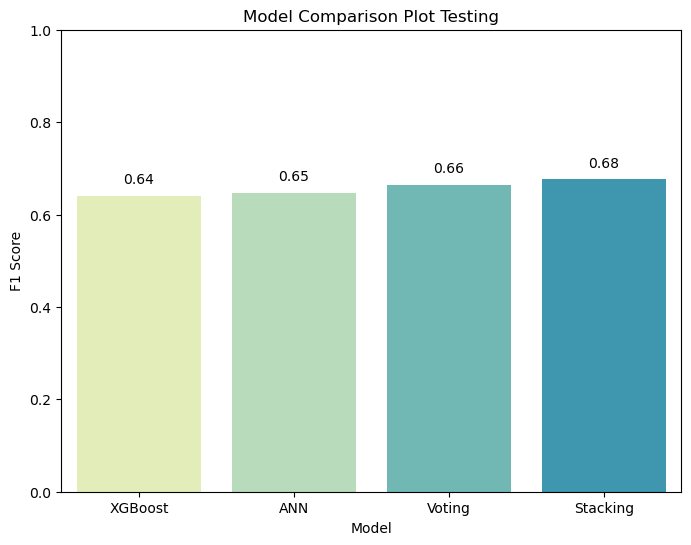

In [50]:
# Visualization model comparison testing:
def barplot_models(model_scores):
    model_names = list(model_scores.keys())
    f1_scores = list(model_scores.values())
    plt.figure(figsize = (8, 6))
    sns.set_palette("YlGnBu")
    bars = sns.barplot(x = model_names, y = f1_scores)
    plt.title("Model Comparison Plot Testing")
    plt.xlabel("Model")
    plt.ylabel("F1 Score")
    plt.ylim(0, 1) 
    for bar, f1_score in zip(bars.patches, f1_scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{f1_score:.2f}", ha = "center", va = "bottom")
    plt.show()

barplot_models(model_scores = {"XGBoost": xgb_f1, "ANN": ann_f1, "Voting": vt_f1, "Stacking": st_f1})

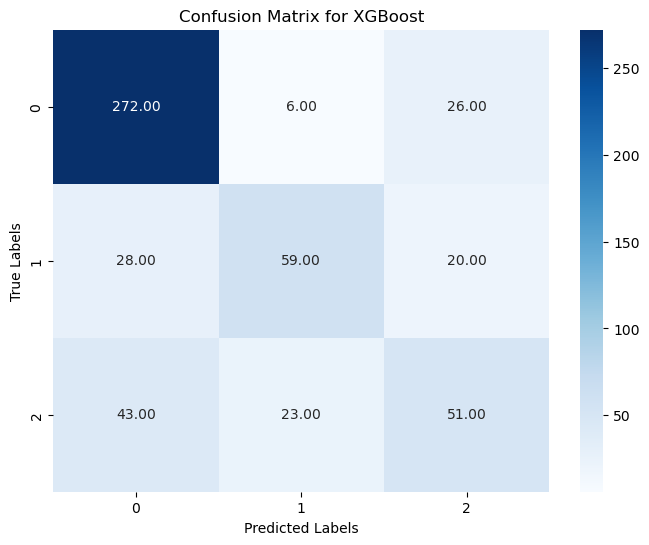

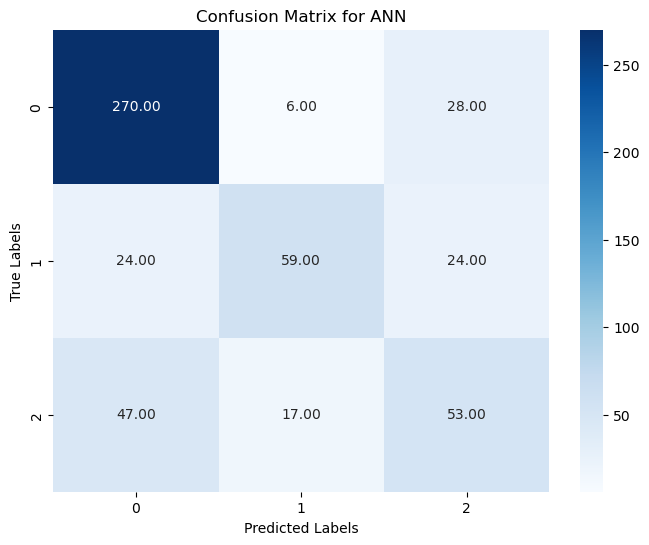

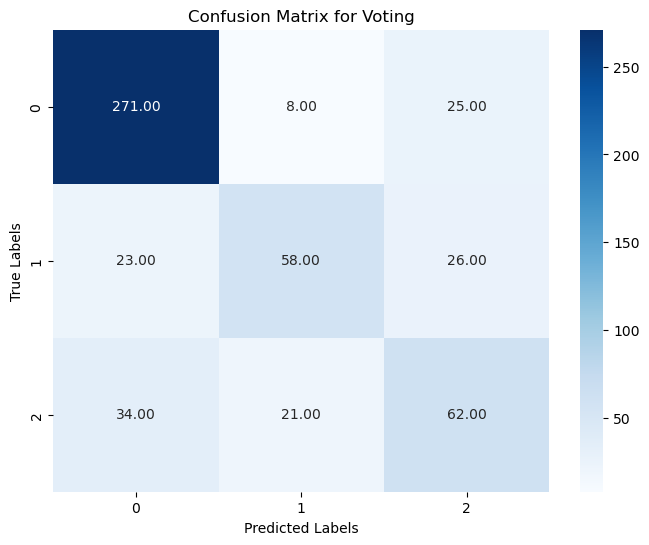

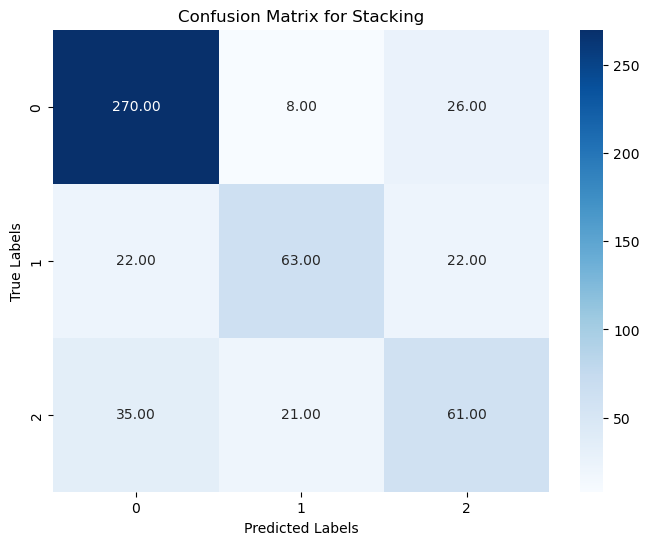

In [41]:
# Confusion matrices (difference predicted and actual):
def confusion_matrices(best_model, model_name):
    y_pred = best_model.predict(X_test)
    y_true = y_test
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (8, 6))
    custom_palette = ["#3182BD"]
    sns.set_palette(custom_palette)
    sns.heatmap(cm, annot = True, fmt = ".2f", cmap = "Blues")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    return cm

xgb_cm = confusion_matrices(best_model_xgb, "XGBoost")
ann_cm = confusion_matrices(best_model_ann, "ANN")
vt_cm = confusion_matrices(best_model_vt, "Voting")
st_cm = confusion_matrices(best_model_st, "Stacking")

In [42]:
# Evaluation metrics:
def calculate_metrics(cm):
    metrics = {}
    for i in range(cm.shape[0]):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        accuracy = (TP + TN) / cm.sum() if cm.sum() != 0 else 0
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        metrics[i] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1_score}
    return metrics

xgb_metrics = calculate_metrics(xgb_cm)
ann_metrics = calculate_metrics(ann_cm)
vt_metrics = calculate_metrics(vt_cm)
st_metrics = calculate_metrics(st_cm)

print("Evaluation metrics xgb:", xgb_metrics)
print("Evaluation metrics ann:", ann_metrics)
print("Evaluation metrics vt:", vt_metrics)
print("Evaluation metrics st:", st_metrics)

Evaluation metrics xgb: {0: {'accuracy': 0.8049242424242424, 'precision': 0.793002915451895, 'recall': 0.8947368421052632, 'f1_score': 0.8408037094281299}, 1: {'accuracy': 0.8541666666666666, 'precision': 0.6704545454545454, 'recall': 0.5514018691588785, 'f1_score': 0.6051282051282051}, 2: {'accuracy': 0.7878787878787878, 'precision': 0.5257731958762887, 'recall': 0.4358974358974359, 'f1_score': 0.47663551401869164}}
Evaluation metrics ann: {0: {'accuracy': 0.8011363636363636, 'precision': 0.7917888563049853, 'recall': 0.8881578947368421, 'f1_score': 0.8372093023255814}, 1: {'accuracy': 0.865530303030303, 'precision': 0.7195121951219512, 'recall': 0.5514018691588785, 'f1_score': 0.6243386243386243}, 2: {'accuracy': 0.7803030303030303, 'precision': 0.5047619047619047, 'recall': 0.452991452991453, 'f1_score': 0.47747747747747754}}
Evaluation metrics vt: {0: {'accuracy': 0.8295454545454546, 'precision': 0.8262195121951219, 'recall': 0.8914473684210527, 'f1_score': 0.8575949367088608}, 1: 

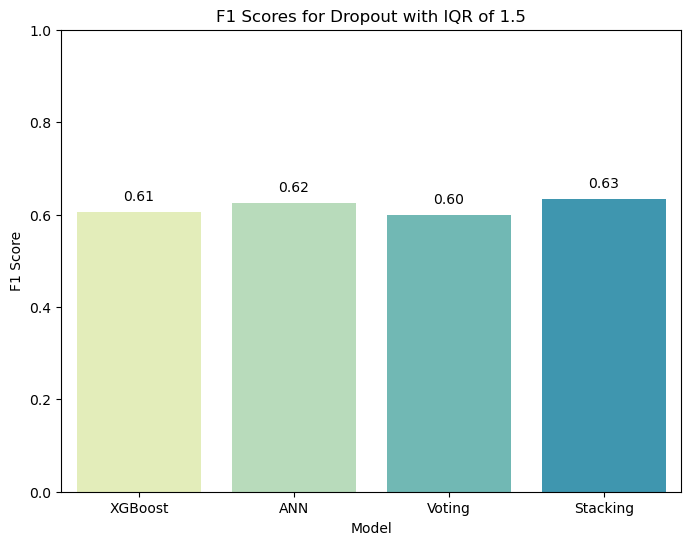

In [57]:
# Visualization model comparison dropout:

# Select F1 score for dropout:
xgb_f1_class_1 = xgb_metrics[1]["f1_score"]
ann_f1_class_1 = ann_metrics[1]["f1_score"]
vt_f1_class_1 = vt_metrics[1]["f1_score"]
st_f1_class_1 = st_metrics[1]["f1_score"]

def barplot_models(model_scores):
    model_names = list(model_scores.keys())
    f1_scores = list(model_scores.values())
    plt.figure(figsize = (8, 6))
    sns.set_palette("YlGnBu")
    bars = sns.barplot(x = model_names, y = f1_scores)
    plt.title("F1 Scores for Dropout with IQR of 1.5")
    plt.xlabel("Model")
    plt.ylabel("F1 Score")
    plt.ylim(0, 1)
    for bar, f1_score in zip(bars.patches, f1_scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{f1_score:.2f}", ha = "center", va = "bottom")
    plt.show()

barplot_models(model_scores = {"XGBoost": xgb_f1_class_1, "ANN": ann_f1_class_1, "Voting": vt_f1_class_1, "Stacking": st_f1_class_1})